In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error as mae
from scipy.signal import savgol_filter, lfilter
from skimage.restoration import denoise_wavelet, estimate_sigma
import pywt, os
from pykalman import KalmanFilter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import winsound
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import tensorflow as tf
tf.config.list_physical_devices('GPU')
import re
from scipy.fftpack import rfft, irfft, fftfreq, rfftfreq

In [51]:
df = pd.read_excel('./calibration_data/concantenate_mixed_data.xlsx')
df = df.drop(columns=['Unnamed: 0'])
df

,sensors,setpoint
0,8.6,20
1,8.6,20
2,9.0,20
3,8.6,20
4,8.6,20
...,...,...
6295,92.2,73
6296,92.2,73
6297,92.2,73
6298,91.9,73


In [52]:
def moving_average_filter(data, window_size=3):
    moving_average = []
    i = 0
    while i < (len(data) - window_size + 1):
        window_average = np.sum(data[i:i+window_size]) / window_size
        
        moving_average.append(
            round(window_average, 2)
        )
        i += 1

    return moving_average

def reshape_list(data, step):
    results = []
    for i in range(0, len(data), step):
        results.append(data[i])

    return results

def kalman_filter2(data, actual_data):
    state_mean = np.array([0, 0])  # Initial state mean
    state_cov = np.eye(2)  # Initial state covariance
    observation_cov = np.var(data)  # Measurement noise covariance

    # Kalman filter update
    state_estimates = []
    state_covariances = []

    for i in range(len(data)):
        # Prediction step
        state_mean_pred = state_mean[0] + state_mean[1] * data[i]
        state_cov_pred = state_cov + np.eye(2)
        
        # Measurement update step
        residual = actual_data[i] - state_mean_pred
        kalman_gain = state_cov_pred[0] / (state_cov_pred[0] + observation_cov)
        state_mean = state_mean_pred + kalman_gain * residual
        state_cov = (np.eye(2) - kalman_gain) @ state_cov_pred
        
        # Store the estimates
        state_mean_pred = round(state_mean_pred, 2)
        state_estimates.append(state_mean_pred)
        state_covariances.append(state_cov_pred[0, 0])

    
    return state_estimates

def notification():
    for _ in range(5):
        winsound.Beep(500, 200)
        winsound.Beep(1200, 200)
        winsound.Beep(500, 200)
        winsound.Beep(1200, 200)

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

def signaltonoise(x_before, x_after):
    x_before = np.array(x_before)
    x_after = np.array(x_after)
    # print(np.sum(x_before**2)/np.sum((x_before-x_after)**2))
    return round(10*np.log(np.sum(x_before**2)/np.sum((x_before-x_after)**2)), 2)

def uncertainty(data):
    temp = []
    data = np.array(data)
    for j in data:
        temp.append(abs(j - data.mean()))

    return round(sum(temp) / len(temp), 2)

In [53]:
polyreg_model = np.poly1d(np.polyfit(df.sensors, df.setpoint, 2))
regression = polyreg_model(df.sensors)

moving_average = moving_average_filter(regression)
savgol = savgol_filter(regression, 51, 2)

wavelet = pywt.wavedec(regression, 'db4')
wavelet = pywt.waverec(wavelet, 'db4',mode='symmetric',axis=-1)

wavelet2 = denoise_wavelet(regression, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

kf = KalmanFilter(transition_matrices = [1],
observation_matrices = [1],
initial_state_mean = 0,
initial_state_covariance = 1,
observation_covariance=1,
transition_covariance=.0001)

mean, cov = kf.filter(regression)
mean, std = mean.squeeze(), np.std(cov.squeeze())

kalman2 = kalman_filter2(df.sensors,regression)

e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: overflow encountered in multiply
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in double_scalars
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in add


In [54]:
x_train, x_test, y_train, y_test = train_test_split(df.sensors, df.setpoint, test_size=0.2, random_state=42)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train.to_numpy().reshape(-1, 1))
# x_train_wavelet = denoise_wavelet(x_train, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

x_test = scaler.transform(x_test.to_numpy().reshape(-1, 1))
# x_test_wavelet = denoise_wavelet(x_test, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')

In [55]:
from keras.layers import Layer
from keras import backend as K

class RBFLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = K.cast_to_floatx(gamma)

    def build(self, input_shape):
#         print(input_shape)
#         print(self.units)
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        diff = K.expand_dims(inputs) - self.mu
        l2 = K.sum(K.pow(diff, 2), axis=1)
        res = K.exp(-1 * self.gamma * l2)
        return res

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

class GRNN :

    def __init__(self,x_train,y_train,x_test,y_test):

        self.x_train= x_train
        self.y_train= y_train
        self.x_test= x_test
        self.y_test= y_test

        self.std     = np.ones((1,self.y_train.size))#np.random.rand(1,self.train_y.size) #Standard deviations(std) are sometimes called RBF widths.

    def activation_func(self,distances): # gaussian kernel
        
        return np.exp(- (distances**2) / 2*(self.std**2) )

    def output(self,i):#sometimes called weight

        distances=np.sqrt(np.sum((self.x_test[i]-self.x_train)**2,axis=1)) # euclidean distance
        
        return self.activation_func(distances)
   
    def denominator(self,i):

        return np.sum(self.output(i))

    def numerator(self,i): 

        return  np.sum(self.output(i) * self.y_train)
    
    def predict(self):

        predict_array = np.array([])

        for i in range(self.y_test.size):
            predict=np.array([self.numerator(i)/self.denominator(i)])
            predict_array=np.append(predict_array,predict)
        
        return predict_array
    
    def mean_squared_error(self):

        return (self.predict()-self.y_test)**2 /self.y_test.size

    def mean_absolute_error(self):

        return np.abs((self.predict()-self.y_test))/self.y_test.size
    
    def root_mean_squared_error(self):

        return np.sqrt(self.mean_squared_error())



model = tf.keras.models.Sequential()
# #v model.add(tf.keras.layers.BatchNormalization())
# model.add(tf.keras.layers.Dense(32, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)))
model.add(tf.keras.layers.Dense(8, activation='gelu', input_shape=(1, )))
model.add(tf.keras.layers.Dense(1, activation='gelu'))
# model.add(tf.keras.layers.Dense(1, activation='linear'))

model.summary()

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics = ["mae"])
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), loss='mean_squared_error', metrics = ["mae"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 16        
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


In [56]:
learning_rate = 0.001
epochs = 2000
batch_size = 32

print(f"============================== Training ==============================")
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))
# print(f"============================== Wavelet Training ==============================")
# history_wavelet = model.fit(x_train_wavelet, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test_wavelet, y_test))

notification()

============================== Training ==============================
Epoch 1/2000
158/158 [==============================] - 0s 917us/step - loss: 2630.5540 - mae: 48.9232 - val_loss: 2571.8418 - val_mae: 48.1891
Epoch 2/2000
158/158 [==============================] - 0s 554us/step - loss: 2537.1101 - mae: 48.0326 - val_loss: 2466.0767 - val_mae: 47.1531
Epoch 3/2000
158/158 [==============================] - 0s 550us/step - loss: 2426.1807 - mae: 46.9255 - val_loss: 2353.8401 - val_mae: 46.0072
Epoch 4/2000
158/158 [==============================] - 0s 557us/step - loss: 2309.4700 - mae: 45.7267 - val_loss: 2233.0742 - val_mae: 44.7508
Epoch 5/2000
158/158 [==============================] - 0s 554us/step - loss: 2182.5432 - mae: 44.3906 - val_loss: 2101.0789 - val_mae: 43.3388
Epoch 6/2000
158/158 [==============================] - 0s 543us/step - loss: 2044.4111 - mae: 42.8907 - val_loss: 1958.8826 - val_mae: 41.7626
Epoch 7/2000
158/158 [==============================] - 0s 561us/

In [60]:
mae_raw = mae(df.sensors, df.setpoint)
mae_raw = round(mae_raw, 2)
snr_raw = signaltonoise(df.sensors, df.setpoint)
snr_raw = round(snr_raw, 2)

mae_regression = mae(regression, df.setpoint)
mae_regression = round(mae_regression, 2)
snr_regression = signaltonoise(regression, df.setpoint)
snr_regression = round(snr_regression, 2)

mae_savgol = mae(savgol, df.setpoint)
mae_savgol = round(mae_savgol, 2)
snr_savgol = signaltonoise(savgol, df.setpoint)
snr_savgol = round(snr_savgol, 2)

mae_wavelet = mae(wavelet, df.setpoint)
mae_wavelet = round(mae_wavelet, 2)
snr_wavelet = signaltonoise(wavelet, df.setpoint)
snr_wavelet = round(snr_wavelet, 2)

mae_wavelet2 = mae(wavelet2, df.setpoint)
mae_wavelet2 = round(mae_wavelet2, 2)
snr_wavelet2 = signaltonoise(wavelet2, df.setpoint)
snr_wavelet2 = round(snr_wavelet2, 2)

# mae_moving_average = mae(moving_average, df.setpoint[1:len(df.setpoint)-1])
# mae_moving_average = round(mae_moving_average, 2)
# snr_moving_average = signaltonoise(moving_average, df.setpoint[1:len(df.setpoint)-1].to_numpy())
# snr_moving_average = round(snr_moving_average, 2)

# mae_kalman = mae(mean, df.setpoint)
# mae_kalman = round(mae_kalman, 2)
# snr_kalman = signaltonoise(mean, df.setpoint)
# snr_kalman = round(snr_kalman, 2)

new_sensor_data = scaler.transform(df.sensors.to_numpy().reshape(-1, 1))
predictions = model.predict(new_sensor_data)
mae_deep_learning = mae(predictions, df.setpoint)
mae_deep_learning = round(mae_deep_learning, 2)
snr_deep_learning = signaltonoise(np.squeeze(predictions), df.setpoint)
snr_deep_learning = round(snr_deep_learning, 2)

predictions_wavelet = denoise_wavelet(np.squeeze(predictions), method='VisuShrink', mode='hard', wavelet_levels=6, wavelet='haar', rescale_sigma='True')
mae_deep_learning_wavelet = mae(predictions_wavelet, df.setpoint)
mae_deep_learning_wavelet = round(mae_deep_learning_wavelet, 2)
snr_deep_learning_wavelet = signaltonoise(predictions_wavelet, df.setpoint)
snr_deep_learning_wavelet = round(snr_deep_learning_wavelet, 2)
print(f"MAE DL Wavelet : {mae_deep_learning_wavelet}")


savgol_deep_learning = savgol_filter(np.squeeze(predictions), 51, 2)
mae_deep_learning_savgol = mae(savgol_deep_learning, df.setpoint)
mae_deep_learning_savgol = round(mae_deep_learning_savgol, 2)
snr_deemae_deep_learning_savgol = signaltonoise(savgol_deep_learning, df.setpoint)
snr_deemae_deep_learning_savgol = round(snr_deemae_deep_learning_savgol, 2)
print(f"MAE DL Savgol : {mae_deep_learning_savgol}")

deep_learning_fourier = filter_signal(np.squeeze(predictions), threshold=1e12)
mae_deep_learning_fourier = mae(deep_learning_fourier, df.setpoint)
mae_deep_learning_fourier = round(mae_deep_learning_fourier, 2)
print(f"MAE DL Fourier : {mae_deep_learning_fourier}")
# mae_rf = mae(rf_data, df.setpoint)
# mae_rf = round(mae_rf, 2)

# mae_gaussian_regression = mae(np.squeeze(gaussian_regression), df.setpoint)
# mae_gaussian_regression = round(mae_gaussian_regression, 2)

# x_train, x_test, y_train, y_test = train_test_split(df.sensors, df.setpoint, test_size=0.2, random_state=42)
# scaler = MinMaxScaler()
# x_train = scaler.fit_transform(x_train.to_numpy().reshape(-1, 1))
# x_test = scaler.transform(x_test.to_numpy().reshape(-1, 1))

# x_test_wavelet = denoise_wavelet(x_test, method='VisuShrink', mode='hard', wavelet_levels=11, wavelet='haar', rescale_sigma='True')
# model_GRNN = GRNN(x_train.reshape(-1,1), y_train.to_numpy().reshape(-1,1), x_test.reshape(-1,1), y_test.to_numpy().reshape(-1,1))
# mae_GRNN = model_GRNN.mean_absolute_error()
# mae_kalman2 = mae(kalman2, df.setpoint)
# mae_kalman2 = round(mae_kalman2, 2)

# notification()

197/197 [==============================] - 0s 302us/step
MAE DL Wavelet : 0.2
MAE DL Savgol : 0.25
MAE DL Fourier : 0.28


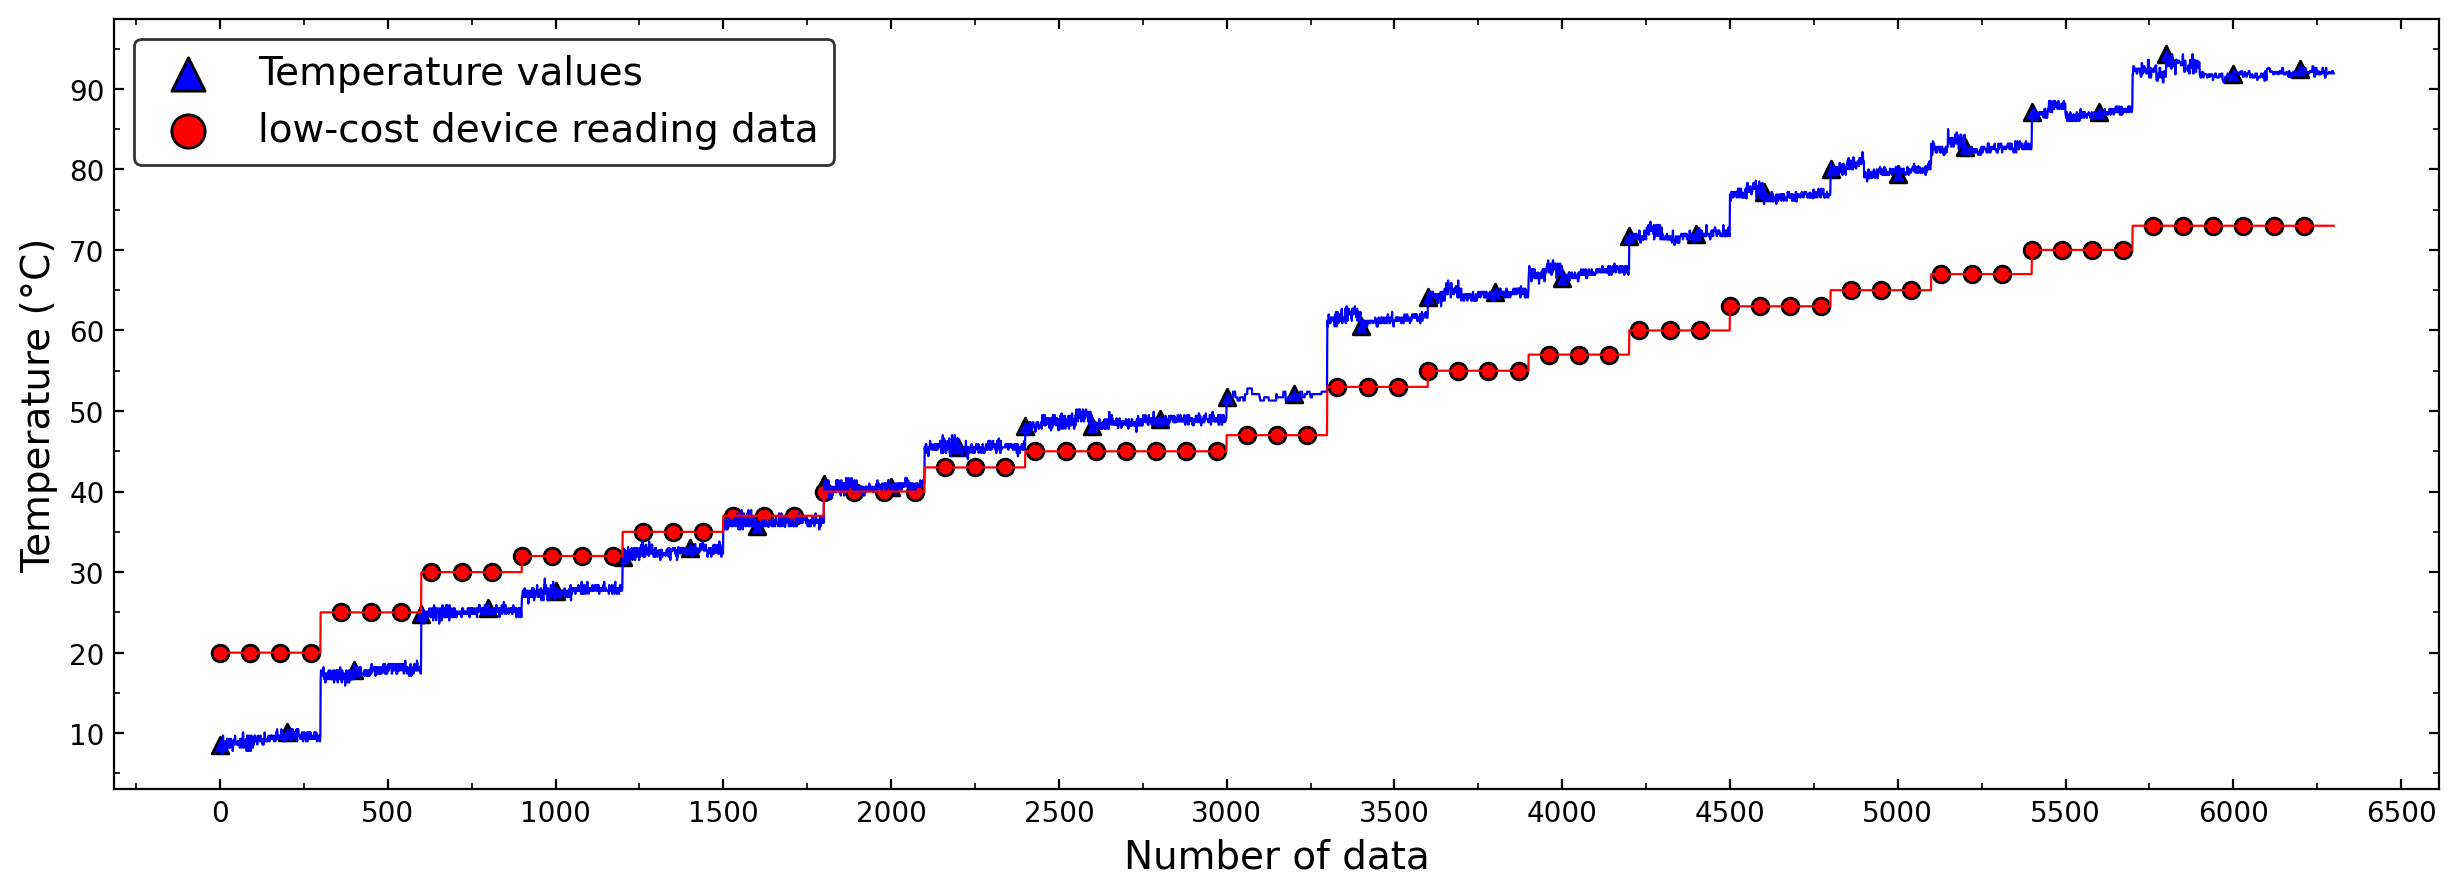

In [61]:
fig, ax = plt.subplots(figsize=(15, 5), dpi=200)

ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(5))

ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(250))

ax.plot(df.sensors, color='blue', linewidth=0.8)
ax.scatter(df.index[::200], df.sensors[::200], label=f'Temperature values', marker='^', c='b', edgecolors='k')

ax.plot(df.setpoint, color='red', linewidth=0.8)
ax.scatter(df.index[::90], df.setpoint[::90], label=f'low-cost device reading data', marker='o', c='r', edgecolors='k')

ax.tick_params(top=True, right=True, which='both', direction='in')
ax.set_xlabel("Number of data", fontsize=14)
ax.set_ylabel("Temperature (°C)", fontsize=14)
lgnd = plt.legend(loc="upper left", numpoints=1, fontsize=14, markerscale=2)
lgnd.get_frame().set_edgecolor('k')


plt.show()

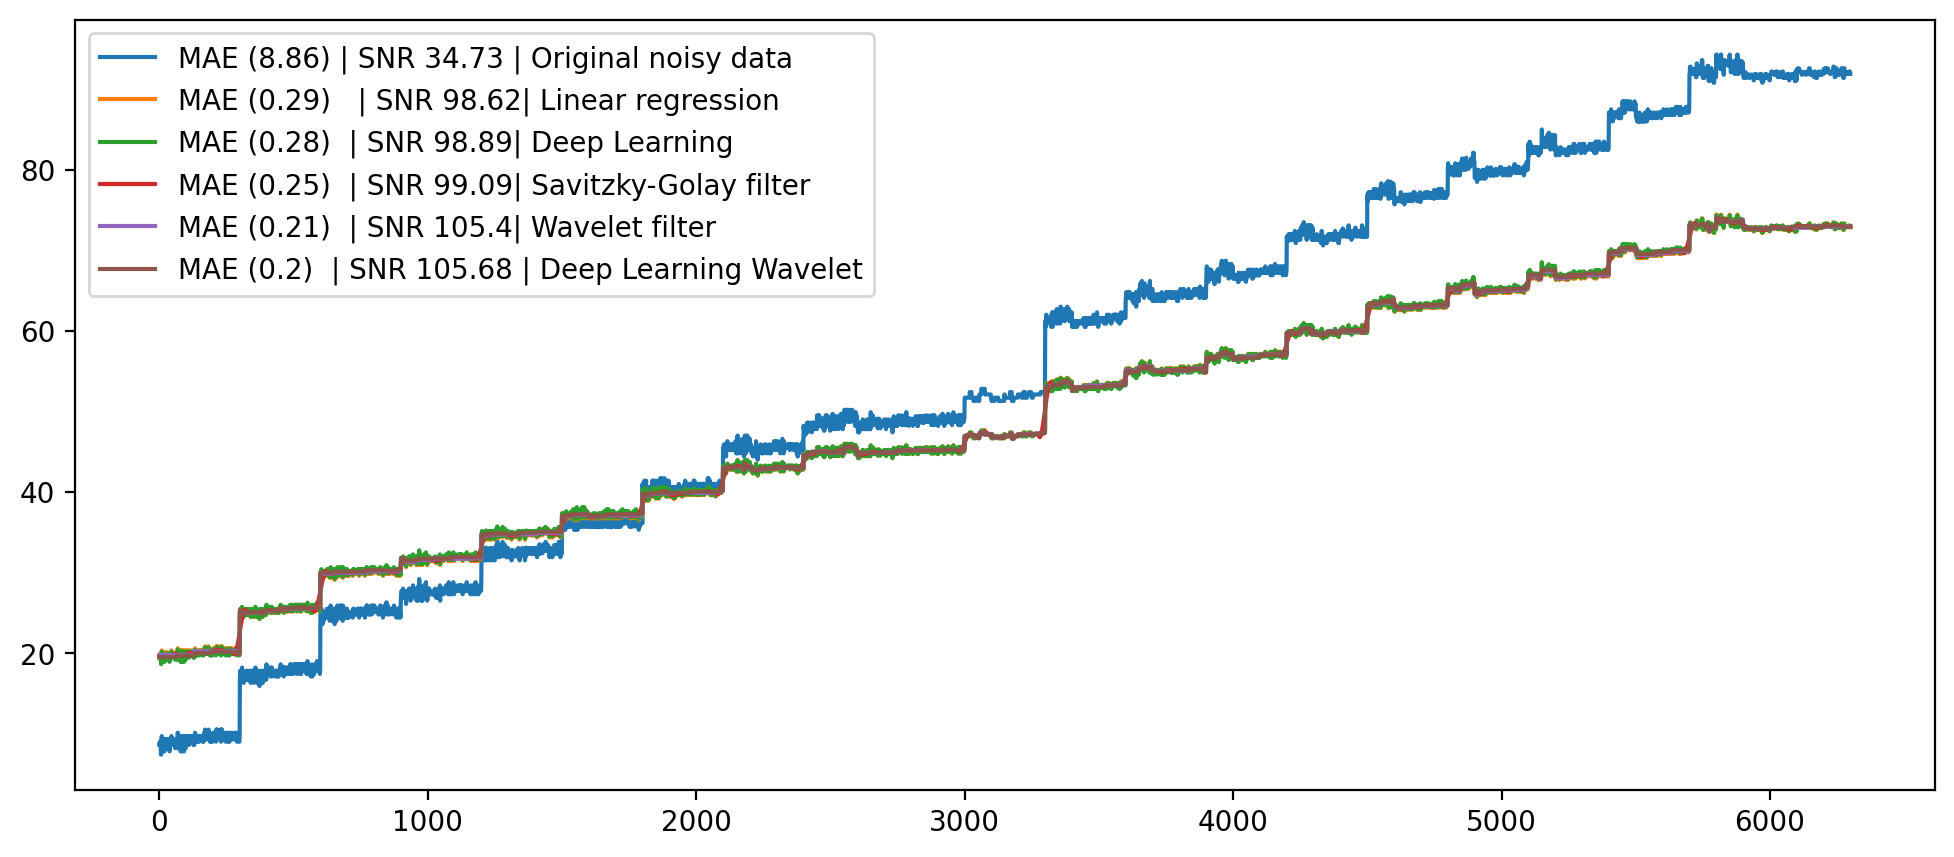

In [62]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=200)

ax.plot(df.sensors, label=f'MAE ({mae_raw}) | SNR {snr_raw} | Original noisy data')
# ax.plot(mean, label=f'MAE ({mae_kalman}) | SNR {snr_kalman} | Kalman filter')
ax.plot(regression, label=f'MAE ({mae_regression})   | SNR {snr_regression}| Linear regression')
ax.plot(predictions, label=f'MAE ({mae_deep_learning})  | SNR {snr_deep_learning}| Deep Learning')
ax.plot(savgol, label=f'MAE ({mae_savgol})  | SNR {snr_savgol}| Savitzky-Golay filter')
# ax.plot(wavelet, label=f'MAE ({mae_wavelet}) | Wavelet filter 1')
#ax.plot(moving_average, label=f'MAE ({mae_moving_average}) | SNR {snr_moving_average} | Moving average filter')
ax.plot(wavelet2, label=f'MAE ({mae_wavelet2})  | SNR {snr_wavelet2}| Wavelet filter')
ax.plot(predictions_wavelet, label=f'MAE ({mae_deep_learning_wavelet})  | SNR {snr_deep_learning_wavelet} | Deep Learning Wavelet')


plt.legend()
plt.show()

40/40 [==============================] - 0s 385us/step - loss: 0.1409 - mae: 0.2891
Test Loss: 0.14094224572181702
Test MAE: 0.2891373634338379


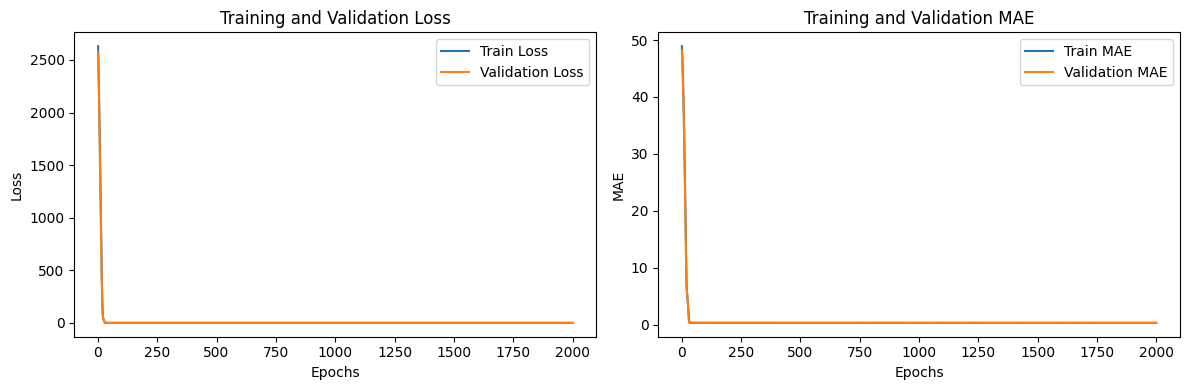

In [63]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test MAE:", test_mae)

# Step 8: Plot accuracy and loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']

pd.DataFrame({
    'train_loss':train_loss,
    'val_loss':val_loss,
    'train_mae':train_mae,
    'val_mae':val_mae,
    }).to_excel('./training_results/8_elu_1_elu_0.32_0.3005_MAE_noisy_0.24.xlsx')
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_mae, label='Train MAE')
plt.plot(epochs_range, val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training and Validation MAE')
plt.legend()

plt.tight_layout()
plt.show()

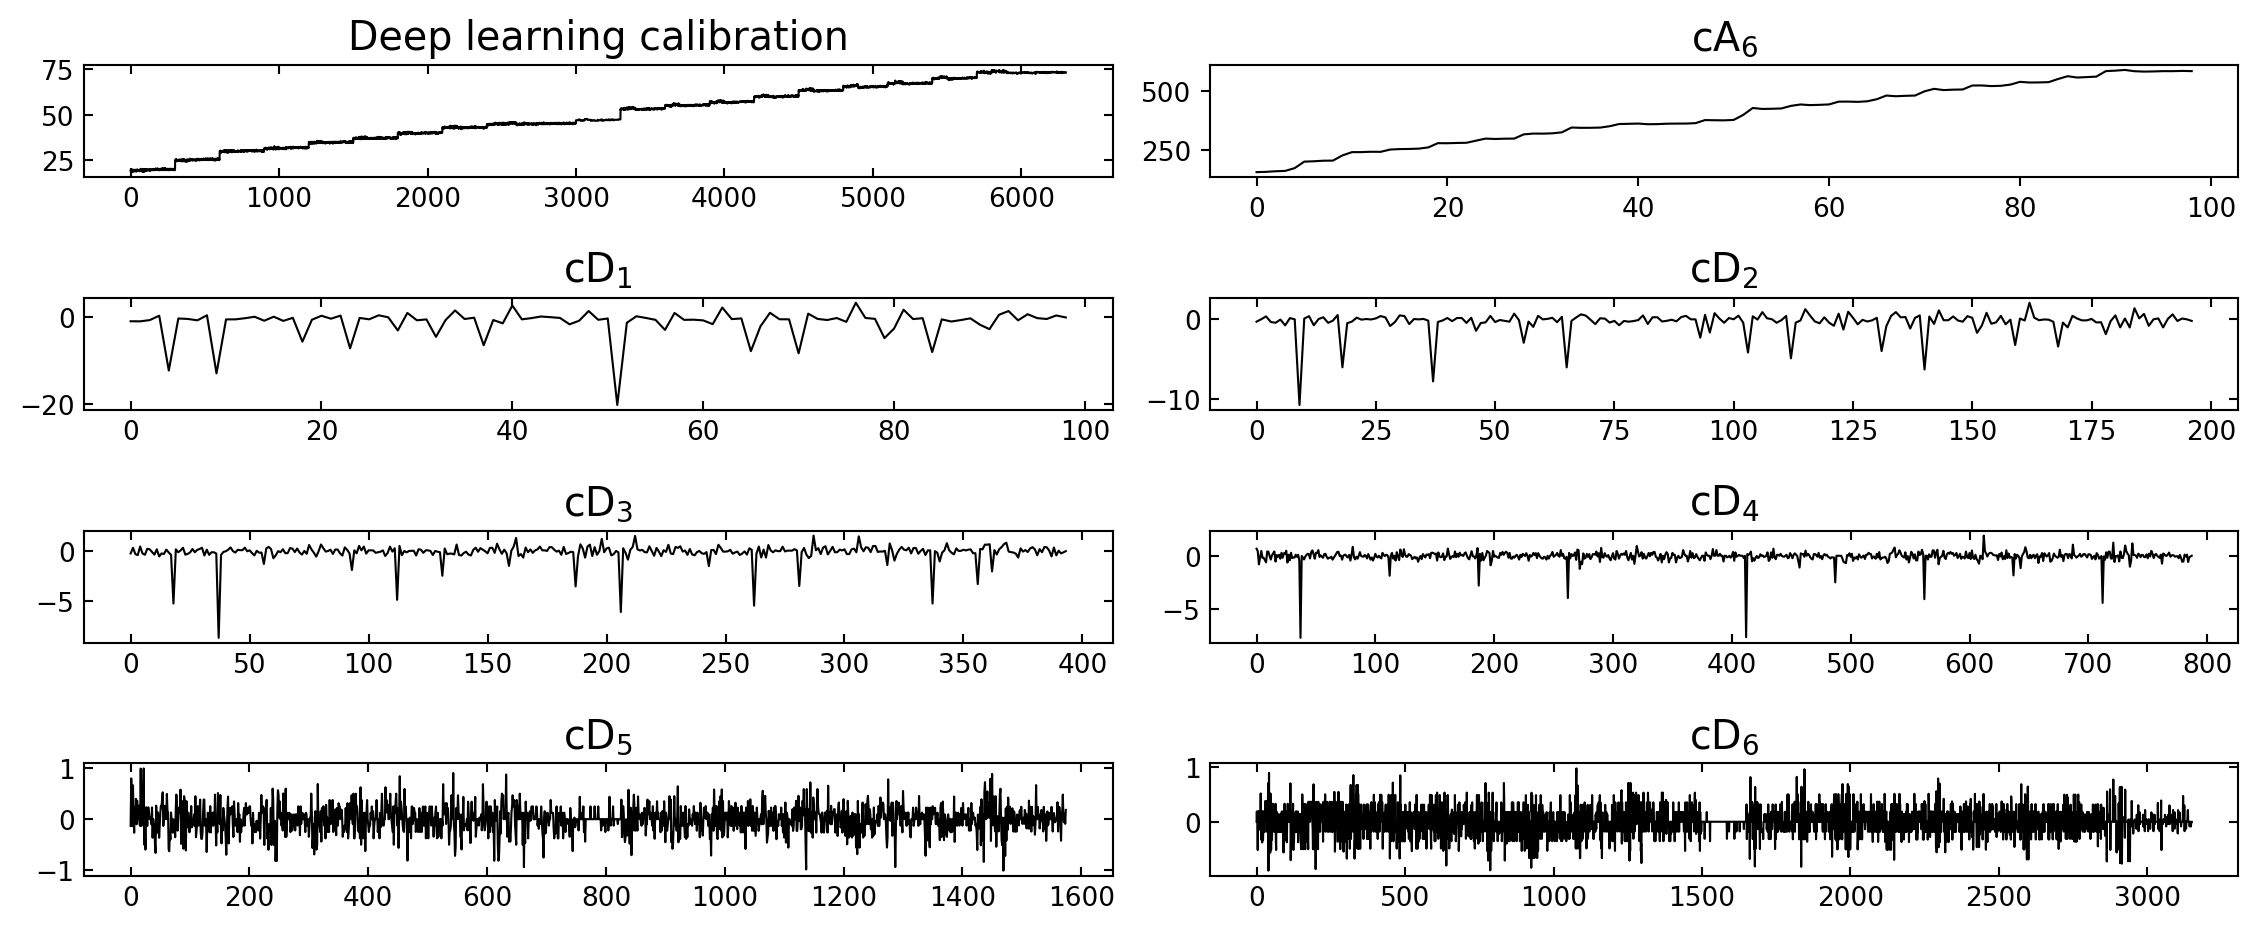

In [64]:
coef = pywt.wavedec(np.squeeze(predictions), 'haar', level=6)
fig, ax = plt.subplots(4, 2, figsize=(12,5), dpi=190)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

count = 0
for row in range(0, 4):
    for col in range(0, 2):
        if ((row == 0) and (col == 0)):
            ax[row][col].plot(np.squeeze(predictions), color='k', linewidth=0.8)
            ax[row][col].set_title(f"Deep learning calibration", fontsize=15)
            ax[row][col].tick_params(top=True, right=True, which='both', direction='in')
        else:
            if count == 0:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"$cA_{6}$", fontsize=15)
            else:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"$cD_{count}$", fontsize=15)
                ax[row][col].tick_params(top=True, right=True, which='both', direction='in')
            
            count += 1
plt.tight_layout()
plt.show()

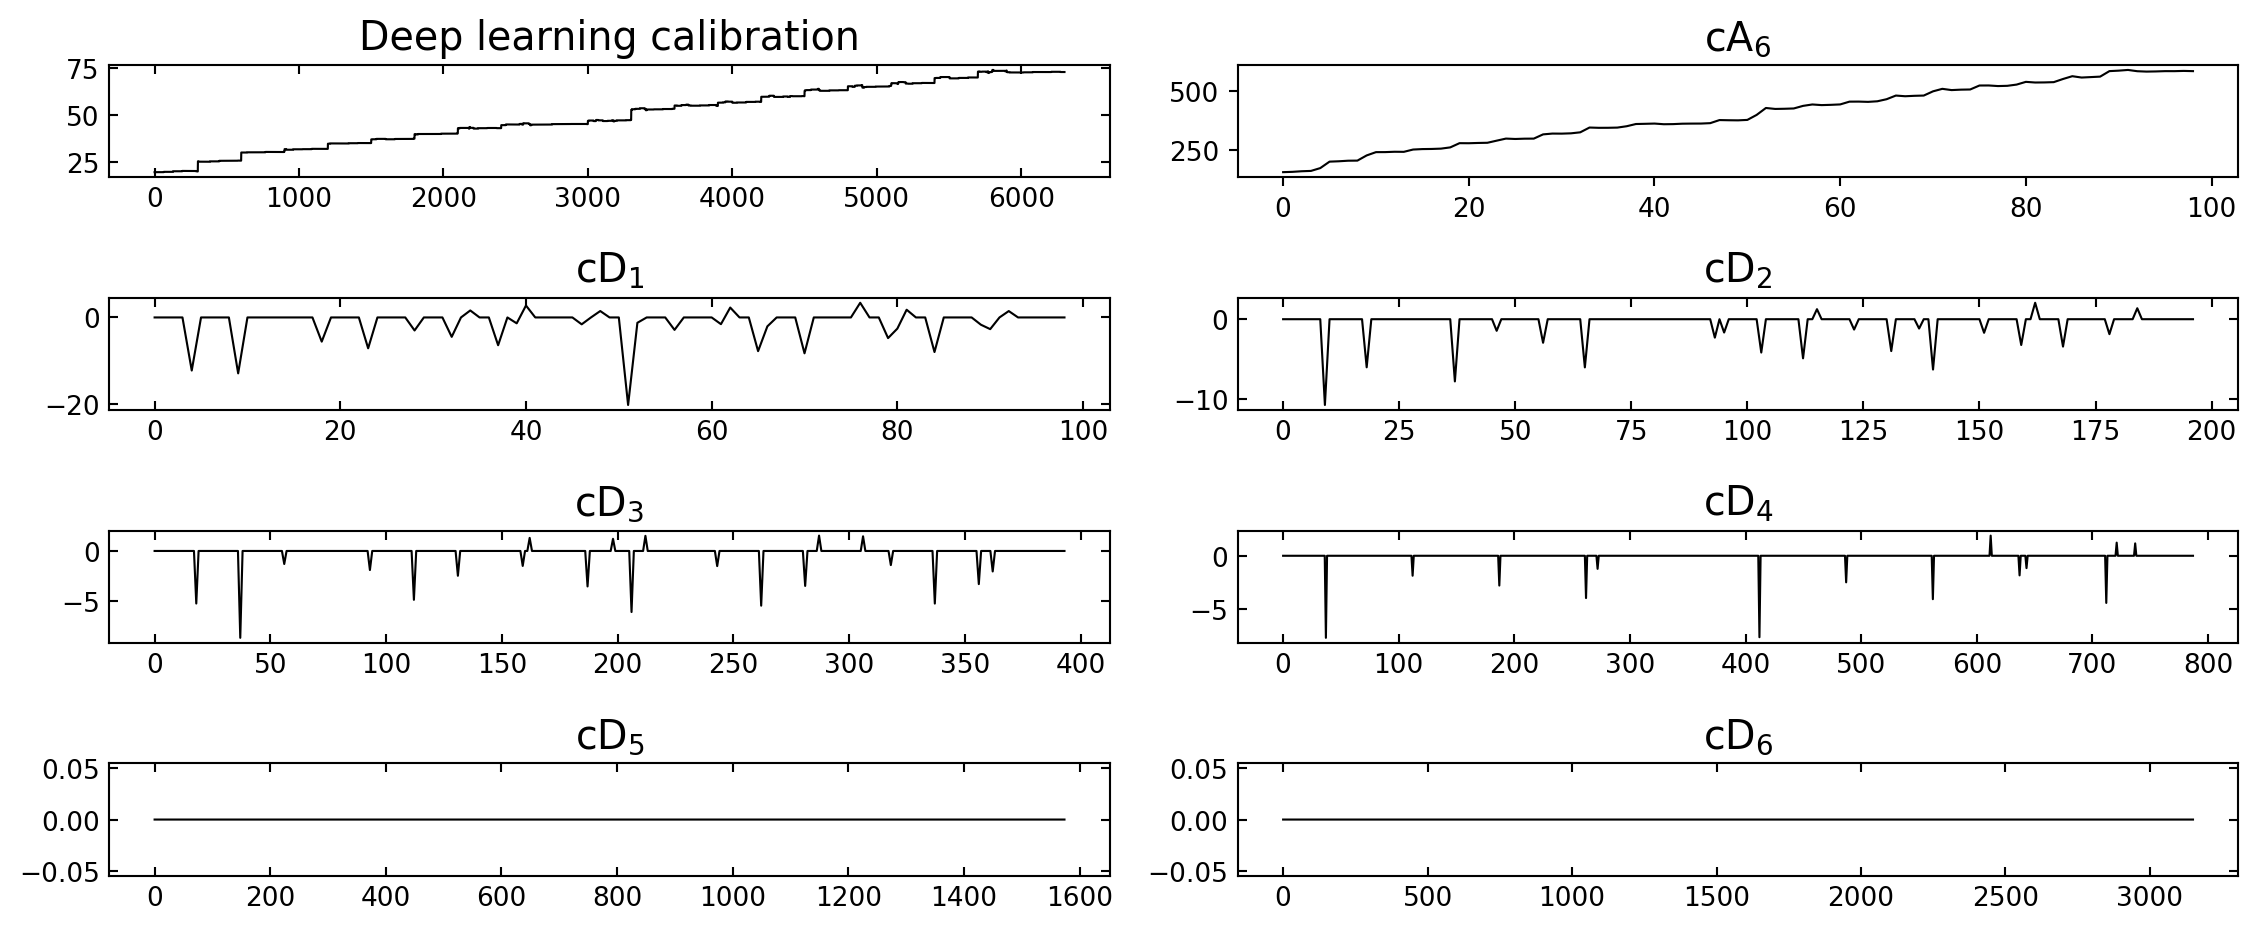

In [65]:
coef = pywt.wavedec(predictions_wavelet, 'haar', level=6)
fig, ax = plt.subplots(4, 2, figsize=(12,5), dpi=190)
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

count = 0
for row in range(0, 4):
    for col in range(0, 2):
        if ((row == 0) and (col == 0)):
            ax[row][col].plot(predictions_wavelet, color='k', linewidth=0.8)
            ax[row][col].set_title(f"Deep learning calibration", fontsize=15)
            ax[row][col].tick_params(top=True, right=True, which='both', direction='in')
        else:
            if count == 0:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"$cA_{6}$", fontsize=15)
            else:
                ax[row][col].plot(coef[count], color='k', linewidth=0.8)
                ax[row][col].set_title(f"$cD_{count}$", fontsize=15)
                ax[row][col].tick_params(top=True, right=True, which='both', direction='in')
            
            count += 1
plt.tight_layout()
plt.show()

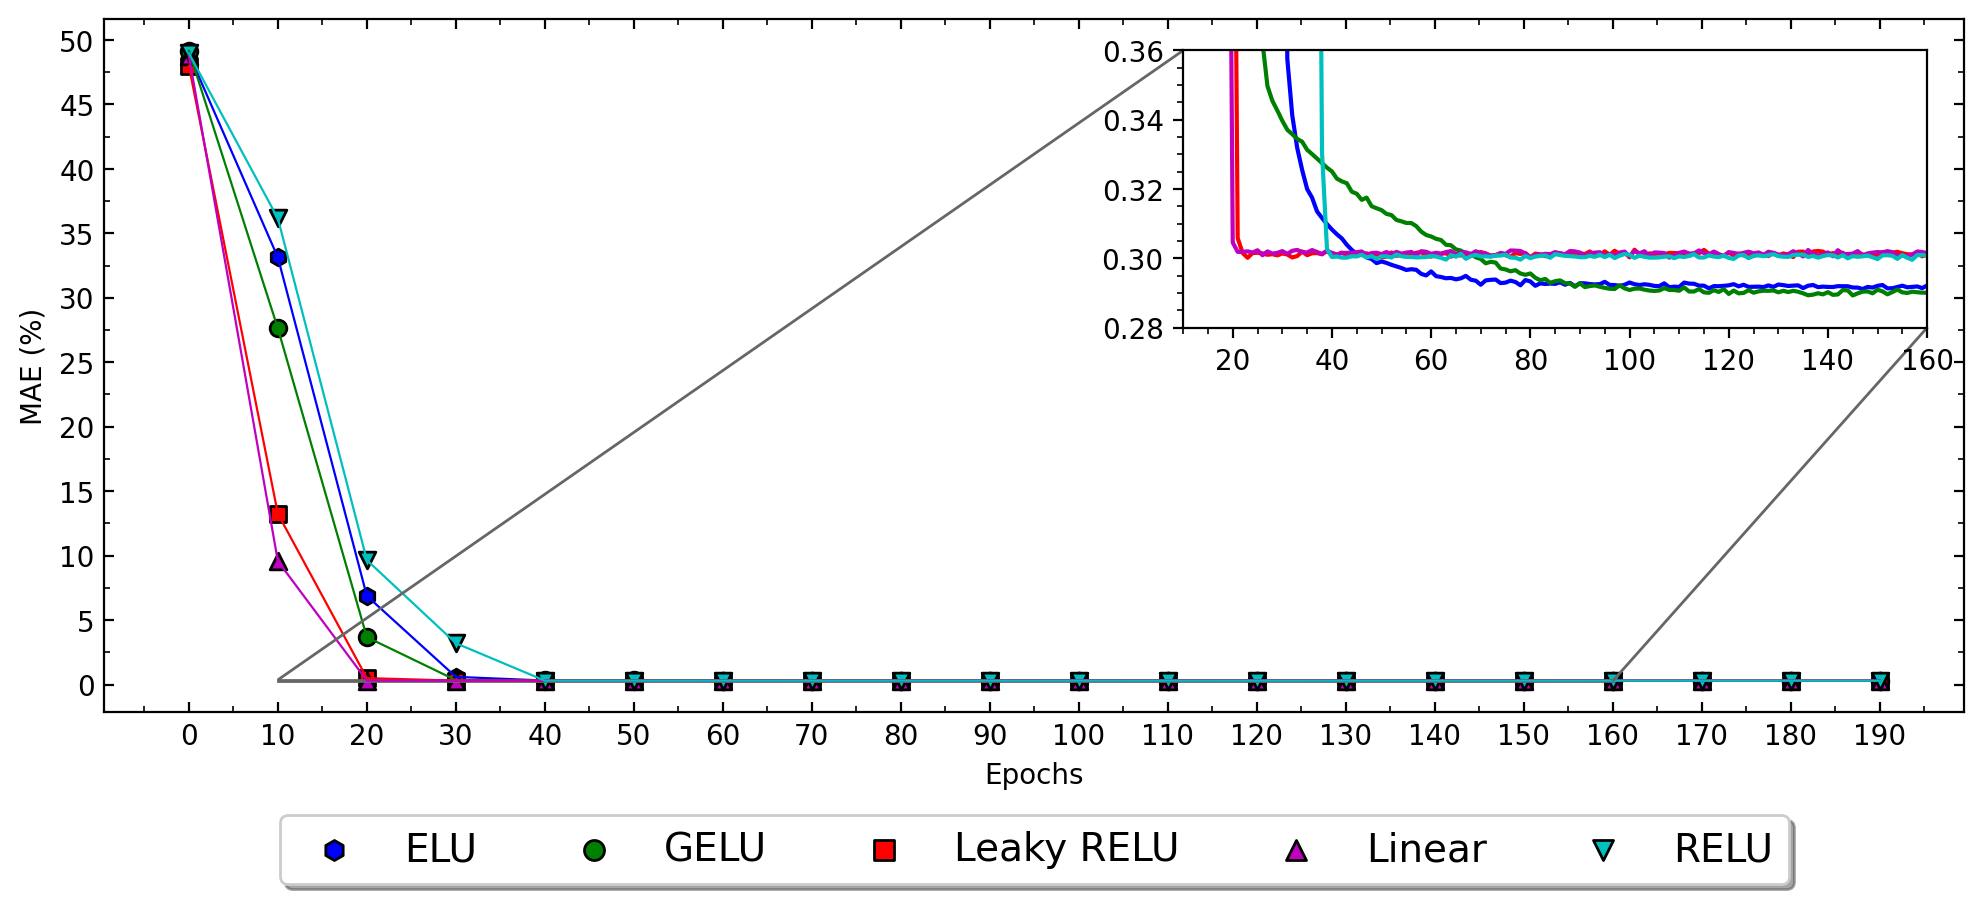

In [80]:
fig, ax = plt.subplots(1, figsize=(12, 5), dpi=200)
function_name = ["ELU", "GELU", "Leaky RELU", "Linear", "RELU"]
markers = ['h', 'o', 's', '^', 'v']
colors = ['blue', 'green', 'red', 'm', 'c']
count = 0
index_hop = 10
end_epoch = 200
line_styles = ['-', '--', '-.', ':', 'solid']

for i in os.listdir('./training_results/'):
    df_data = pd.read_excel(f'./training_results/{i}')
    ax.scatter(df_data.index[:end_epoch][::index_hop], df_data.train_mae[:end_epoch][::index_hop], marker=markers[count], facecolors='none', c=colors[count], edgecolor='k', label=function_name[count])
    ax.plot(df_data.index[:end_epoch][::index_hop], df_data.train_mae[:end_epoch][::index_hop], color=colors[count], linewidth=0.8)
    count += 1

ax.set_ylabel("MAE (%)")
ax.set_xlabel("Epochs")
# Create the zoomed-in plot
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(2.5))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(top=True, right=True, which='both', direction='in')
ax_zoom = ax.inset_axes([0.580, 0.555, 0.4, 0.4]) 
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.4")
# For the minor ticks, use no labels; default NullFormatter.


ax_zoom.set_ylim(0.28, 0.36)
ax_zoom.set_xlim(10, 160)
ax_zoom.yaxis.set_major_locator(MultipleLocator(0.02))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.005))
ax_zoom.xaxis.set_major_locator(MultipleLocator(20))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(5))

count = 0
for i in os.listdir('./training_results/'):
    df_data = pd.read_excel(f'./training_results/{i}')
    ax_zoom.plot(df_data.train_mae.to_numpy()[:250], label=i, color=colors[count])
    count += 1


box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5, markerscale=1.2, fontsize=14)


plt.show()

In [16]:
class KalmanFilter(object):
    def __init__(self, F = None, B = None, H = None, Q = None, R = None, P = None, x0 = None):

        if(F is None or H is None):
            raise ValueError("Set proper system dynamics.")

        self.n = F.shape[1]
        self.m = H.shape[1]

        self.F = F
        self.H = H
        self.B = 0 if B is None else B
        self.Q = np.eye(self.n) if Q is None else Q
        self.R = np.eye(self.n) if R is None else R
        self.P = np.eye(self.n) if P is None else P
        self.x = np.zeros((self.n, 1)) if x0 is None else x0

    def predict(self, u = 0):
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = self.R + np.dot(self.H, np.dot(self.P, self.H.T))
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(S))
        self.x = self.x + np.dot(K, y)
        I = np.eye(self.n)
        self.P = np.dot(np.dot(I - np.dot(K, self.H), self.P), (I - np.dot(K, self.H)).T) + np.dot(np.dot(K, self.R), K.T)

def kalman_filter(F, B, H, Q, R, x0, P0, measurements, controls=None):
    """
    Kalman filter implementation.

    Parameters:
        F: State transition matrix
        B: Control input matrix
        H: Measurement matrix
        Q: Process noise covariance matrix
        R: Measurement noise covariance matrix
        x0: Initial state estimate
        P0: Initial error covariance matrix
        measurements: List of measurements
        controls: List of control inputs (optional)

    Returns:
        List of state estimates and error covariance matrices.
    """
    num_states = F.shape[0]
    num_measurements = H.shape[0]
    num_steps = len(measurements)

    # Initialize state estimate and error covariance
    x_estimate = x0
    P_estimate = P0

    # Lists to store the estimates for each step
    x_estimates = [x_estimate]
    P_estimates = [P_estimate]

    for i in range(num_steps):
        # Prediction step
        if controls is not None:
            x_predict = F @ x_estimate + B @ controls[i]
        else:
            x_predict = F @ x_estimate
        P_predict = F @ P_estimate @ F.T + Q

        # Measurement update step
        K = P_predict @ H.T @ np.linalg.inv(H @ P_predict @ H.T + R)
        z = measurements[i]
        x_estimate = x_predict + K @ (z - H @ x_predict)
        P_estimate = (np.eye(num_states) - K @ H) @ P_predict

        # Append the estimates for this step
        x_estimates.append(x_estimate)
        P_estimates.append(P_estimate)

    return x_estimates, P_estimates

In [17]:
df_bali_kalman = pd.read_excel("./docs/Kalman-Percobaan ke 3 dat suhu tgl 22 juli.xlsx")
df_bali_kalman = df_bali_kalman.drop(columns=["Unnamed: 0"])
df_bali_kalman


,waktu,T4HotTEC,Kalman T4HotTEC,T6PCM2,Kalman T6PCM2
0,10,23.5,21.382883,24.71,22.483874
1,20,23.7,22.547154,24.71,23.602425
2,30,23.7,22.980580,24.71,24.018831
3,40,23.7,23.212575,24.73,24.248165
4,50,43.4,29.208245,24.71,24.385330
...,...,...,...,...,...
1577,15780,49.7,49.771082,0.76,0.759999
1578,15790,49.7,49.751879,0.76,0.760000
1579,15800,49.8,49.764879,0.76,0.760000
1580,15810,49.7,49.747351,0.76,0.760000


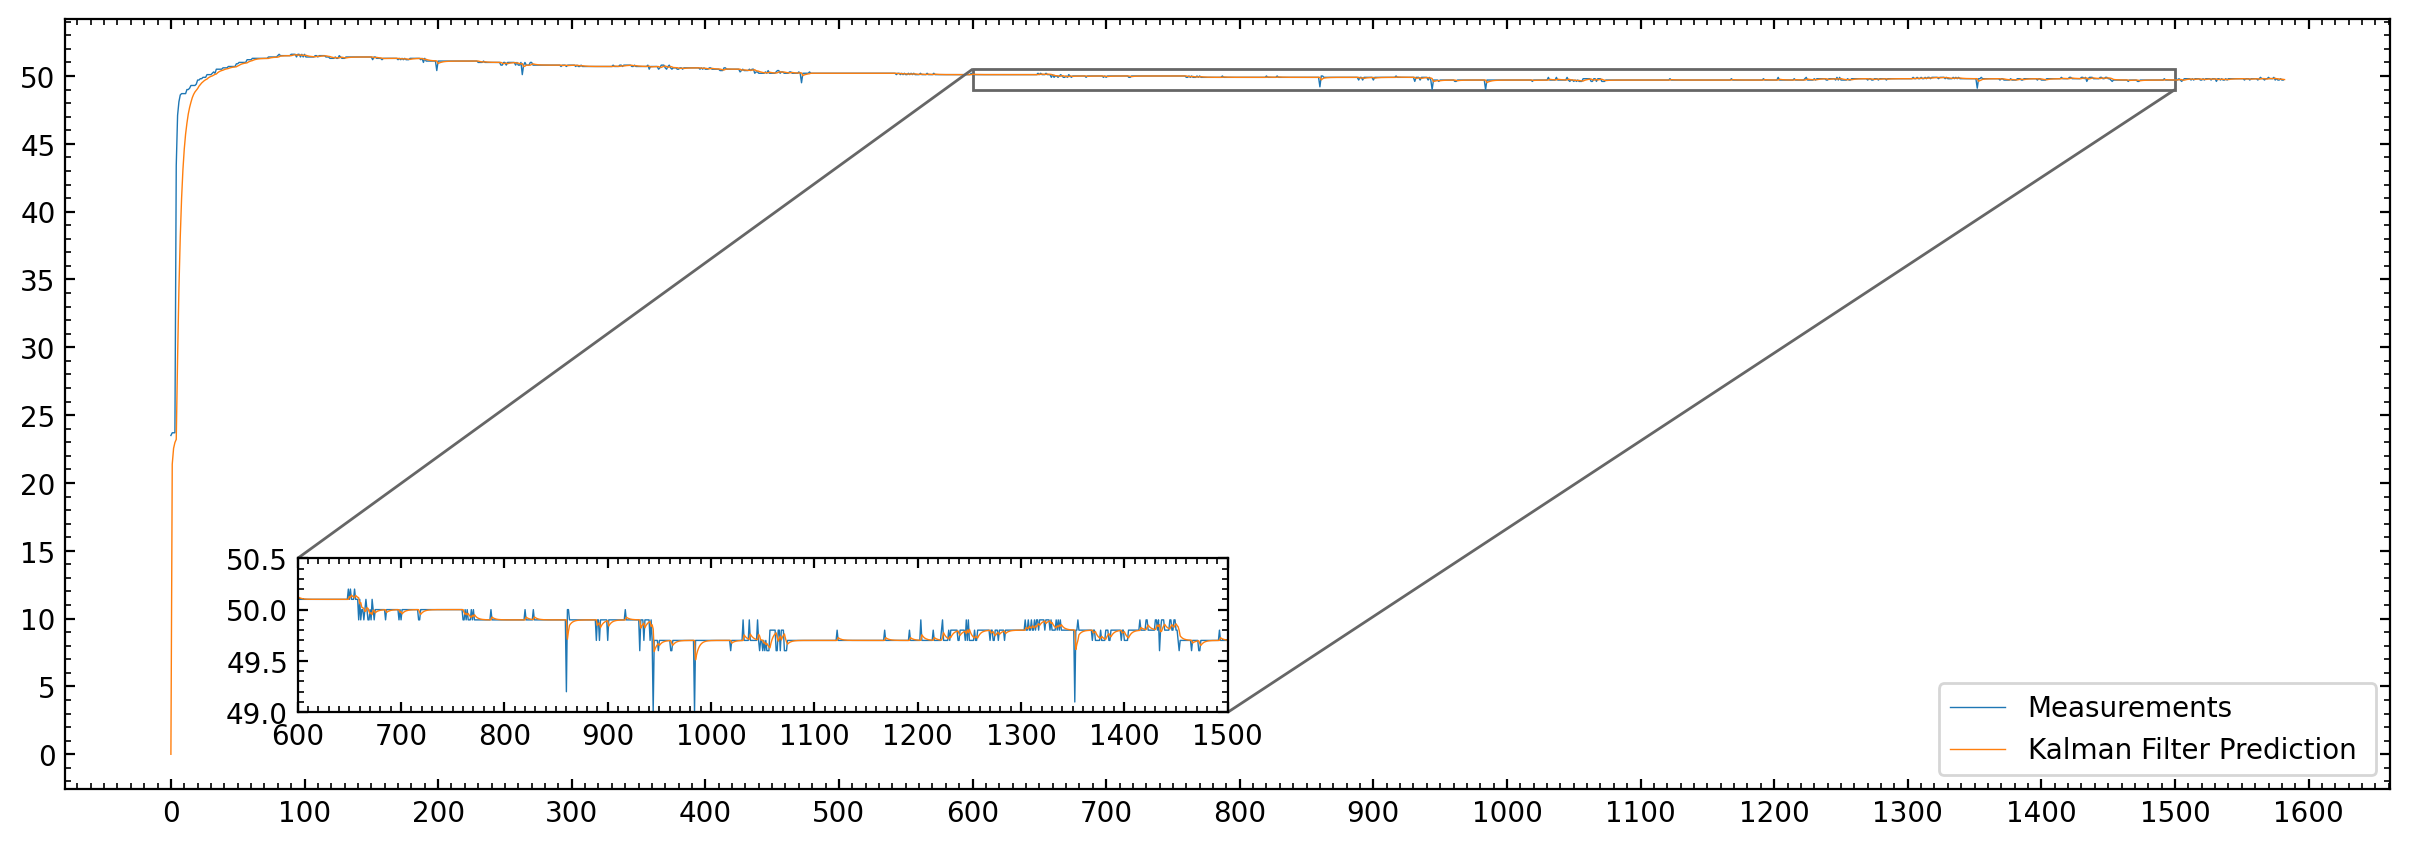

In [18]:
dt = 1.0/60
F = np.array([[1, dt, 0], [0, 1, dt], [0, 0, 1]])
H = np.array([1, 0, 0]).reshape(1, 3)
Q = np.array([[0.05, 0.05, 0.0], [0.05, 0.05, 0.0], [0.0, 0.0, 0.0]])
R = np.array([0.5]).reshape(1, 1)

x = df_bali_kalman.waktu
measurements = df_bali_kalman.T4HotTEC

kf = KalmanFilter(F = F, H = H, Q = Q, R = R)
predictions = []

for z in measurements:
    predictions.append(np.dot(H,  kf.predict())[0])
    kf.update(z)

F = np.array([[1]])
B = np.array([[1]])
H = np.array([[1]])
Q = np.array([[0.01]])
R = np.array([[0.1]])
x0 = np.array([[0]])  # Initial state estimate
P0 = np.array([[1]]) 


# Perform Kalman filtering
x_estimates, P_estimates = kalman_filter(F, B, H, Q, R, x0, P0, measurements)
x_estimates = np.squeeze(x_estimates)

fig, ax = plt.subplots(1, figsize=(15, 5), dpi=200)
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(100))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(top=True, right=True, which='both', direction='in')

HOP_LENGTH = 50
ax.plot(range(len(measurements)), measurements, label = 'Measurements', linewidth=0.5)
# ax.plot(range(len(predictions)), np.array(predictions), label = 'Kalman Filter Prediction', linewidth=0.5)
ax.plot(range(len(x_estimates)), np.array(x_estimates), label = 'Kalman Filter Prediction ', linewidth=0.5)


ax_zoom = ax.inset_axes([0.1, 0.1, 0.4, 0.2]) 
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.4")
ax_zoom.set_ylim(49, 50.5)
ax_zoom.set_xlim(600, 1500)
ax_zoom.yaxis.set_major_locator(MultipleLocator(0.5))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_zoom.xaxis.set_major_locator(MultipleLocator(100))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(10))
ax_zoom.tick_params(top=True, right=True, which='both', direction='in')

ax_zoom.plot(range(len(measurements)), measurements         , linewidth=0.5)
# ax_zoom.plot(range(len(predictions)), np.array(predictions) , linewidth=0.5)
ax_zoom.plot(range(len(x_estimates)), np.array(x_estimates) , linewidth=0.5)
# ax_zoom.scatter(range(len(measurements))[::HOP_LENGTH], measurements[::HOP_LENGTH], label = 'Measurements', marker='^',facecolor='none', edgecolor='k' )
# ax_zoom.scatter(range(len(predictions))[::HOP_LENGTH], np.array(predictions)[::HOP_LENGTH], label = 'Kalman Filter Prediction', marker='o', facecolor='none', edgecolor='k')
# ax_zoom.scatter(range(len(x_estimates))[::HOP_LENGTH], np.array(x_estimates)[::HOP_LENGTH], label = 'Kalman Filter Prediction 2', marker='o', facecolor='none', edgecolor='k')

ax.legend()
plt.show()

In [19]:
dict_bali_kalman = {}
F = np.array([[1]])
B = np.array([[1]])
H = np.array([[1]])
Q = np.array([[0.01]])
R = np.array([[0.1]])
x0 = np.array([[0]])  # Initial state estimate
P0 = np.array([[1]]) 


# Perform Kalman filtering

for i in ['T4HotTEC', 'T6PCM2']:
    dict_bali_kalman["waktu"] = df_bali_kalman.waktu.to_list()
    dict_bali_kalman[i] = df_bali_kalman[i].to_list()

    x_estimates, P_estimates = kalman_filter(F, B, H, Q, R, x0, P0, df_bali_kalman[i])
    x_estimates = np.squeeze(x_estimates)[1:]
    dict_bali_kalman[f"Kalman {i}"] = x_estimates


for i in dict_bali_kalman.keys():
    print(f"{i} : {len(dict_bali_kalman[i])}")
pd.DataFrame(dict_bali_kalman).to_excel("Kalman-Percobaan ke 3 dat suhu tgl 22 juli.xlsx")

waktu : 1582
T4HotTEC : 1582
Kalman T4HotTEC : 1582
T6PCM2 : 1582
Kalman T6PCM2 : 1582


In [20]:
dict_NI = {}
df_NI_join = pd.read_csv('./NI/test 21 Juni 2023.lvm', sep='\t')
for j in df_NI_join.columns:
    dict_NI[j] = []
    
for i in os.listdir('./NI'):
    PATH = './NI/' + i
    df_NI_join = pd.read_csv(PATH, sep='\t')
    for j in df_NI_join.columns:
        for k in df_NI_join[j]:
            dict_NI[j].append(k)

df_NI = pd.DataFrame(dict_NI)        
df_NI = df_NI.replace({',': '.'}, regex=True)
df_NI.to_excel("All_NI_Data.xlsx")

df_NI.X_Value = [i for i in range(0, len(df_NI.index))]

for i in ['Temperature_2', 'Temperature_3', 'Temperature_4', 'Temperature_5', 'Temperature_10']:
    val = df_NI[i][0:5578]
    df_NI[i][0:5578] = val[::-1]

df_NI

e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,X_Value,Temperature_0,Temperature_1,Temperature_2,Temperature_3,Temperature_4,Temperature_5,Temperature_6,Temperature_7,Temperature_8,Temperature_9,Temperature_10,Temperature_11,Temperature_12,Temperature_13,Temperature_14,Temperature_15,Comment
0,0,20.072257,19.990246,15.870223,15.992244,15.935999,16.005723,19.619734,19.586593,19.979125,19.905912,16.285281,19.464915,19.516137,19.862816,19.561100,19.964297,NaN
1,1,20.050597,19.961402,15.865313,16.003835,15.943873,16.008948,19.594590,19.587869,19.981559,19.880773,16.289899,19.503043,19.490759,19.850652,19.530160,19.932673,NaN
2,2,20.052110,19.955964,15.876789,16.010662,15.953024,16.019493,19.613947,19.589845,19.980059,19.884834,16.293471,19.517071,19.511509,19.861664,19.556240,19.956427,NaN
3,3,20.048898,19.958776,15.867463,15.993435,15.937655,15.998548,19.610040,19.603087,19.989822,19.898305,16.272995,19.543061,19.514554,19.857757,19.537731,19.949509,NaN
4,4,20.059369,19.976199,15.853866,16.000292,15.931729,16.003080,19.612635,19.604060,19.992648,19.901363,16.286356,19.531056,19.507879,19.852474,19.556318,19.952335,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11280,11280,74.329654,74.228295,73.002551,72.986664,73.047528,72.904766,72.755290,72.718368,71.646251,71.844749,72.328335,72.554569,72.615211,71.906960,72.792883,72.095384,NaN
11281,11281,74.324399,74.235122,73.002219,72.976262,73.061293,72.912266,72.755629,72.697673,71.636296,71.847102,72.318604,72.537678,72.582879,71.899467,72.789866,72.073569,NaN
11282,11282,74.315042,74.223304,72.973618,72.974513,73.021951,72.883441,72.746495,72.671533,71.614629,71.818274,72.283512,72.512209,72.537271,71.860346,72.754551,72.062420,NaN
11283,11283,74.287758,74.208774,72.956178,72.951479,73.014357,72.879874,72.720999,72.670204,71.603006,71.807323,72.275917,72.492754,72.541760,71.874681,72.757250,72.042965,NaN


e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:37: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:38: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.


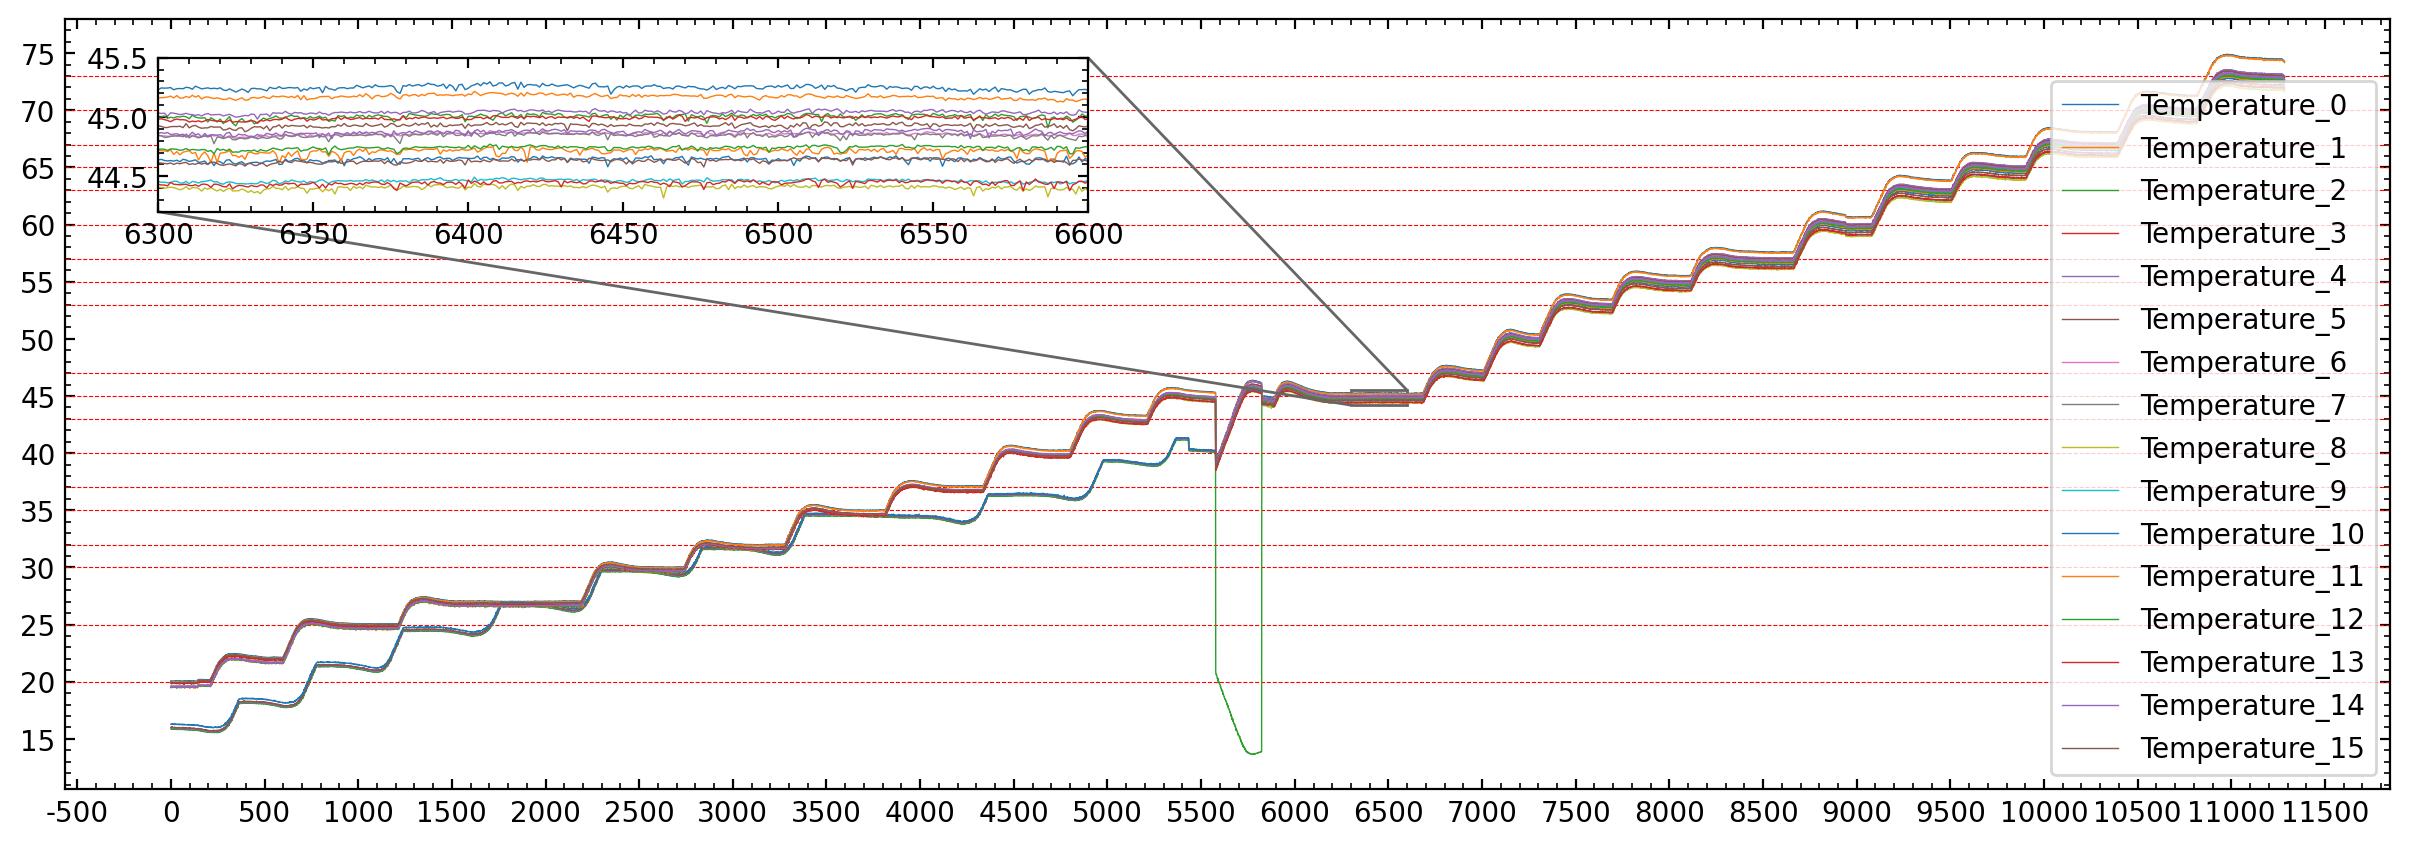

In [21]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=200)
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(500))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.tick_params(top=True, right=True, which='both', direction='in')

ax_zoom = ax.inset_axes([0.04, 0.75, 0.4, 0.2]) 
mark_inset(ax, ax_zoom, loc1=3, loc2=1, fc="none", ec="0.4")
ax_zoom.set_ylim(44.2, 45.5)
ax_zoom.set_xlim(6300, 6600)
ax_zoom.yaxis.set_major_locator(MultipleLocator(0.5))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.1))
ax_zoom.xaxis.set_major_locator(MultipleLocator(50))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(10))
ax_zoom.tick_params(top=True, right=True, which='both', direction='in')

TEMPERATURE_TRUE = [20, 25, 30, 32, 35, 37, 40, 43, 45, 47, 53, 55, 57, 60, 63, 65, 67, 70, 73]
HOP_LENGTH = 150



for i in TEMPERATURE_TRUE:
    ax.axhline(i, df_NI['X_Value'].min(), df_NI['X_Value'].max(), linestyle='--', linewidth=0.4, color='r')

for i in df_NI.columns:
    if (i != 'Comment'):
        df_NI[i] = df_NI[i].astype(float)
        if (i != 'X_Value'):
        
            ax.plot(df_NI['X_Value'], df_NI[i], label = i, linewidth=0.5)
            ax_zoom.plot(df_NI['X_Value'], df_NI[i], label = i, linewidth=0.5)
            
            ax.scatter(df_NI['X_Value'][::HOP_LENGTH], df_NI[i][::HOP_LENGTH], marker='x', facecolor='none', edgecolor='k')
            ax_zoom.scatter(df_NI['X_Value'][::HOP_LENGTH], df_NI[i][::HOP_LENGTH], marker='x', facecolor='none', edgecolor='k')


ax.legend()
plt.show()

In [22]:
NI_dict = {}

for i in df_NI.columns:
    if (i != 'Comment'):
        df_NI[i] = df_NI[i].astype(float)
        if (i != 'X_Value'):
            for count in range(0, len(TEMPERATURE_TRUE)):
                NI_dict[f"{TEMPERATURE_TRUE[count]}"] = []
                for j in df_NI[i]:
                    if ((j > TEMPERATURE_TRUE[count] - 0.5) and (j < TEMPERATURE_TRUE[count] + 0.5)):
                        NI_dict[f"{TEMPERATURE_TRUE[count]}"].append(j)

    count += 1

UNIQUE_LIST = df.setpoint.unique()
INDEKS_TEMP = [0]

v0 = 25
count = 1
indeks = 0
Sensor_dict = {}
raw_dict = {}
actual_dict = {}

STAT = True

for i in df.setpoint:
    if i == v0:
        count += 1
        if count < len(TEMPERATURE_TRUE):
            v0 = TEMPERATURE_TRUE[count]
            #print(f"{indeks}, {i}, {v0}")
            INDEKS_TEMP.append(indeks)
    
    if (v0 == 73) and (STAT == True):
        INDEKS_TEMP.append(indeks)
        # print(f"{indeks}, {i}, {v0}")
        STAT = False
    
    indeks += 1
INDEKS_TEMP = [0,
 300,
 600,
 900,
 1200,
 1500,
 1800,
 2100,
 2400,
 3000,
 3300,
 3600,
 3900,
 4200,
 4500,
 4800,
 5100,
 5400,
 5700,
 6300]
for i in range(0,len(TEMPERATURE_TRUE)):
    #print(INDEKS_TEMP[i+1])
    if i < len(TEMPERATURE_TRUE):
        #print(f"{i}, {TEMPERATURE_TRUE[i]}, {INDEKS_TEMP[i]}:{INDEKS_TEMP[i+1]}")
        Sensor_dict[f"{TEMPERATURE_TRUE[i]}"] = predictions_wavelet[INDEKS_TEMP[i]:INDEKS_TEMP[i+1]]
        raw_dict[f"{TEMPERATURE_TRUE[i]}"] = df.sensors[INDEKS_TEMP[i]:INDEKS_TEMP[i+1]]
        actual_dict[f"{TEMPERATURE_TRUE[i]}"] = df.setpoint[INDEKS_TEMP[i]:INDEKS_TEMP[i+1]]


20  | NI std  ; 0.1, deep-wavelet : 0.23999999463558197
20  | NI mean ; 20.01, deep-wavelet : 19.93000030517578
25  | NI std  ; 0.16, deep-wavelet : 0.23000000417232513
25  | NI mean ; 25.05, deep-wavelet : 25.290000915527344
30  | NI std  ; 0.17, deep-wavelet : 0.10999999940395355
30  | NI mean ; 29.97, deep-wavelet : 30.09000015258789
32  | NI std  ; 0.15, deep-wavelet : 0.1599999964237213
32  | NI mean ; 31.88, deep-wavelet : 31.709999084472656
35  | NI std  ; 0.19, deep-wavelet : 0.10999999940395355
35  | NI mean ; 34.86, deep-wavelet : 34.880001068115234
37  | NI std  ; 0.18, deep-wavelet : 0.10000000149011612
37  | NI mean ; 36.89, deep-wavelet : 37.16999816894531
40  | NI std  ; 0.16, deep-wavelet : 0.10999999940395355
40  | NI mean ; 39.89, deep-wavelet : 39.939998626708984
43  | NI std  ; 0.19, deep-wavelet : 0.14000000059604645
43  | NI mean ; 42.9, deep-wavelet : 43.02000045776367
45  | NI std  ; 0.24, deep-wavelet : 0.2199999988079071
45  | NI mean ; 44.8, deep-wavelet : 45

e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:63: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:65: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
e:\BAGAS\code\thermocouple-monitoring-GUI\env\lib\site-packages\ipykernel_launcher.py:81: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)).

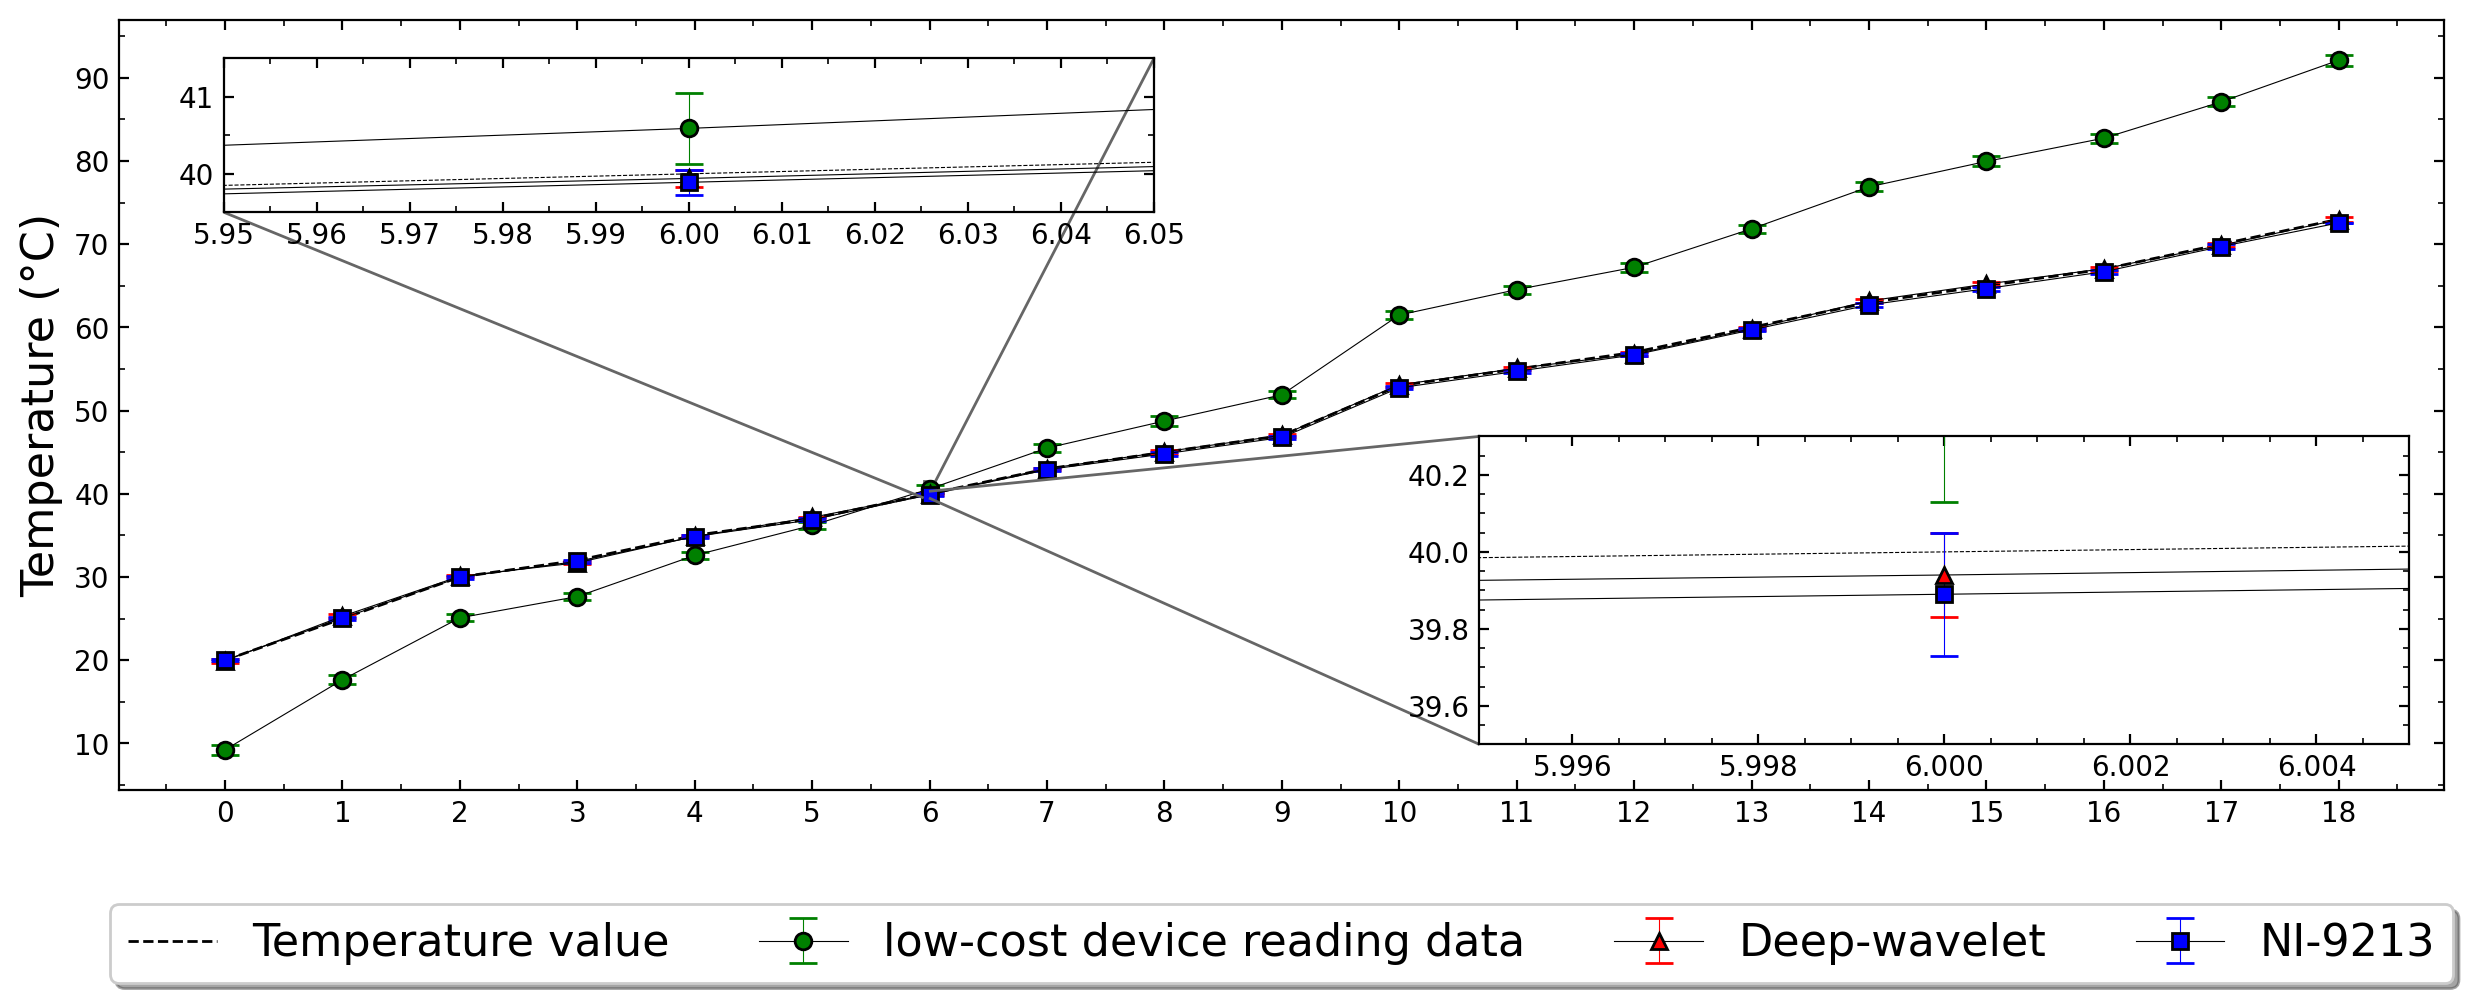

In [23]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=200)
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.tick_params(top=True, right=True, which='both', direction='in')

FONT_SIZE = 16
std_data = {"raw-mean":[], "Sensor-mean":[], "NI-mean":[], "raw-MAE":[], "Sensor-MAE":[], "NI-MAE":[], "raw-std":[], "Sensor-std":[], "NI-std":[], "raw-uncertainty":[], "Sensor-uncertainty":[], "NI-uncertainty":[], "raw-SNR":[], "Sensor-SNR":[], "NI-SNR":[]}

for i in Sensor_dict.keys():
    std_data["NI-mean"].append(
        round(np.mean(np.array(NI_dict[i])), 2)
        )
    std_data["Sensor-mean"].append(
        round(np.mean(np.array(Sensor_dict[i])), 2)
        )
    std_data["raw-mean"].append(
        round(np.mean(np.array(raw_dict[i])), 2)
    )

    std_data["NI-std"].append(
        round(np.std(np.array(NI_dict[i])), 2)
    )
    std_data["Sensor-std"].append(
        round(np.std(np.array(Sensor_dict[i])), 2)
    )
    std_data["raw-std"].append(
        round(np.std(np.array(raw_dict[i])), 2)
    )

    print(f"{i}  | NI std  ; {round(np.std(np.array(NI_dict[i])), 2)}, deep-wavelet : {round(np.std(np.array(Sensor_dict[i])), 2)}")
    print(f"{i}  | NI mean ; {round(np.mean(np.array(NI_dict[i])), 2)}, deep-wavelet : {round(np.mean(np.array(Sensor_dict[i])), 2)}")
    mean = str(np.round(Sensor_dict[i].mean(), decimals=2))
    std_data["NI-uncertainty"].append(f"{round(np.mean(np.array(NI_dict[i])), 2)}±{uncertainty(NI_dict[i])}")
    std_data["Sensor-uncertainty"].append(f"{mean}±{uncertainty(Sensor_dict[i])}")
    std_data["raw-uncertainty"].append(f"{round(np.mean(np.array(raw_dict[i])), 2)}±{uncertainty(raw_dict[i])}")

    std_data["NI-SNR"].append(signaltonoise(NI_dict[i][:70], actual_dict[i][:70]))
    std_data["Sensor-SNR"].append(signaltonoise(Sensor_dict[i], actual_dict[i]))
    std_data["raw-SNR"].append(signaltonoise(raw_dict[i], actual_dict[i]))
    
    std_data["NI-MAE"].append(round(mae(NI_dict[i][:70], actual_dict[i][:70]), 2))
    std_data["Sensor-MAE"].append(round(mae(Sensor_dict[i], actual_dict[i]), 2))
    std_data["raw-MAE"].append(round(mae(raw_dict[i], actual_dict[i]), 2))
    
for i in std_data.keys():
    if re.search("uncertainty", i):
        MD = []
        for j in std_data[i]:
            MD.append(float(j.split("±")[-1]))
        
        MD = np.array(MD)
        print(f"{i}-{round(MD.mean(),2)}")

    else:
        print(f"{i}-{round(np.array(std_data[i]).mean(), 2)}")
    # print(f"Uncertainty {i} | NI : {uncertainty(NI_dict[i])}, Wavelet : {uncertainty(Sensor_dict[i])}, Sensors : {uncertainty(raw_dict[i])} | Mean {i} | NI : {round(np.mean(np.array(NI_dict[i])), 2)}, Wavelet : {round(Sensor_dict[i].mean(), 2)}, Sensors : {round(np.mean(np.array(raw_dict[i])), 2)}")
    
ax.plot(np.arange(0,len(TEMPERATURE_TRUE),1 ), TEMPERATURE_TRUE, linewidth=1, color='k', label='Temperature value', linestyle='--')
ax.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["raw-mean"]     , yerr=std_data["raw-std"]       , label="low-cost device reading data"     ,capsize=5, mfc='g', fmt ='k', marker='o', color='k', lw=0.4, elinewidth=0.4, ecolor='g')
ax.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["Sensor-mean"]  , yerr=std_data["Sensor-std"]    , label="Deep-wavelet"                     ,capsize=5, mfc='r', fmt ='k', marker='^', color='k', lw=0.4, elinewidth=0.4, ecolor='r')
ax.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["NI-mean"]      , yerr=std_data["NI-std"]        , label="NI-9213"                          ,capsize=5, mfc='b', fmt ='k', marker='s', color='k', lw=0.4, elinewidth=0.4, ecolor='b')
ax.set_ylabel("Temperature (°C)", fontsize=FONT_SIZE)

ax_zoom = ax.inset_axes([0.045, 0.75, 0.4, 0.2]) 
mark_inset(ax, ax_zoom, loc1=3, loc2=1, fc="none", ec="0.4")
ax_zoom.set_ylim(39.5, 41.5)
ax_zoom.set_xlim(5.95, 6.05)
ax_zoom.yaxis.set_major_locator(MultipleLocator(1))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.5))
ax_zoom.xaxis.set_major_locator(MultipleLocator(0.01))
ax_zoom.xaxis.set_minor_locator(MultipleLocator(0.005))
ax_zoom.xaxis.set_major_formatter('{x:.2f}')
ax_zoom.tick_params(top=True, right=True, which='both', direction='in')


ax_zoom.plot(np.arange(0,len(TEMPERATURE_TRUE),1 ), TEMPERATURE_TRUE, linewidth=0.4, color='k', linestyle='--')
ax_zoom.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["raw-mean"] , yerr=std_data["raw-std"]          ,capsize=5, mfc='g', fmt ='k', marker='o', color='k', lw=0.4, elinewidth=0.4, ecolor='g')
ax_zoom.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["Sensor-mean"] , yerr=std_data["Sensor-std"]    ,capsize=5, mfc='r', fmt ='k', marker='^', color='k', lw=0.4, elinewidth=0.4, ecolor='r')
ax_zoom.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["NI-mean"]     , yerr=std_data["NI-std"]        ,capsize=5, mfc='b', fmt ='k', marker='s', color='k', lw=0.4, elinewidth=0.4, ecolor='b')

ax_zoom2 = ax.inset_axes([0.585, 0.059, 0.4, 0.4]) 
mark_inset(ax, ax_zoom2, loc1=3, loc2=2, fc="none", ec="0.4")
ax_zoom2.set_ylim(39.5, 40.3)
ax_zoom2.set_xlim(5.995, 6.005)
ax_zoom2.yaxis.set_major_locator(MultipleLocator(0.2))
ax_zoom2.yaxis.set_minor_locator(MultipleLocator(0.05))
ax_zoom2.xaxis.set_major_locator(MultipleLocator(0.002))
ax_zoom2.xaxis.set_minor_locator(MultipleLocator(0.0005))
ax_zoom2.xaxis.set_major_formatter('{x:.3f}')
ax_zoom2.tick_params(top=True, right=True, which='both', direction='in')


ax_zoom2.plot(np.arange(0,len(TEMPERATURE_TRUE),1 ), TEMPERATURE_TRUE, linewidth=0.4, color='k', linestyle='--')
ax_zoom2.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["raw-mean"] , yerr=std_data["raw-std"]          ,capsize=5, mfc='g', fmt ='k', marker='o', color='k', lw=0.4, elinewidth=0.4, ecolor='g')
ax_zoom2.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["Sensor-mean"] , yerr=std_data["Sensor-std"]    ,capsize=5, mfc='r', fmt ='k', marker='^', color='k', lw=0.4, elinewidth=0.4, ecolor='r')
ax_zoom2.errorbar(np.arange(0,len(TEMPERATURE_TRUE),1 ), std_data["NI-mean"]     , yerr=std_data["NI-std"]        ,capsize=5, mfc='b', fmt ='k', marker='s', color='k', lw=0.4, elinewidth=0.4, ecolor='b')



pd.DataFrame(std_data).to_excel('data_summary.xlsx')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5, fontsize=FONT_SIZE)

plt.show()

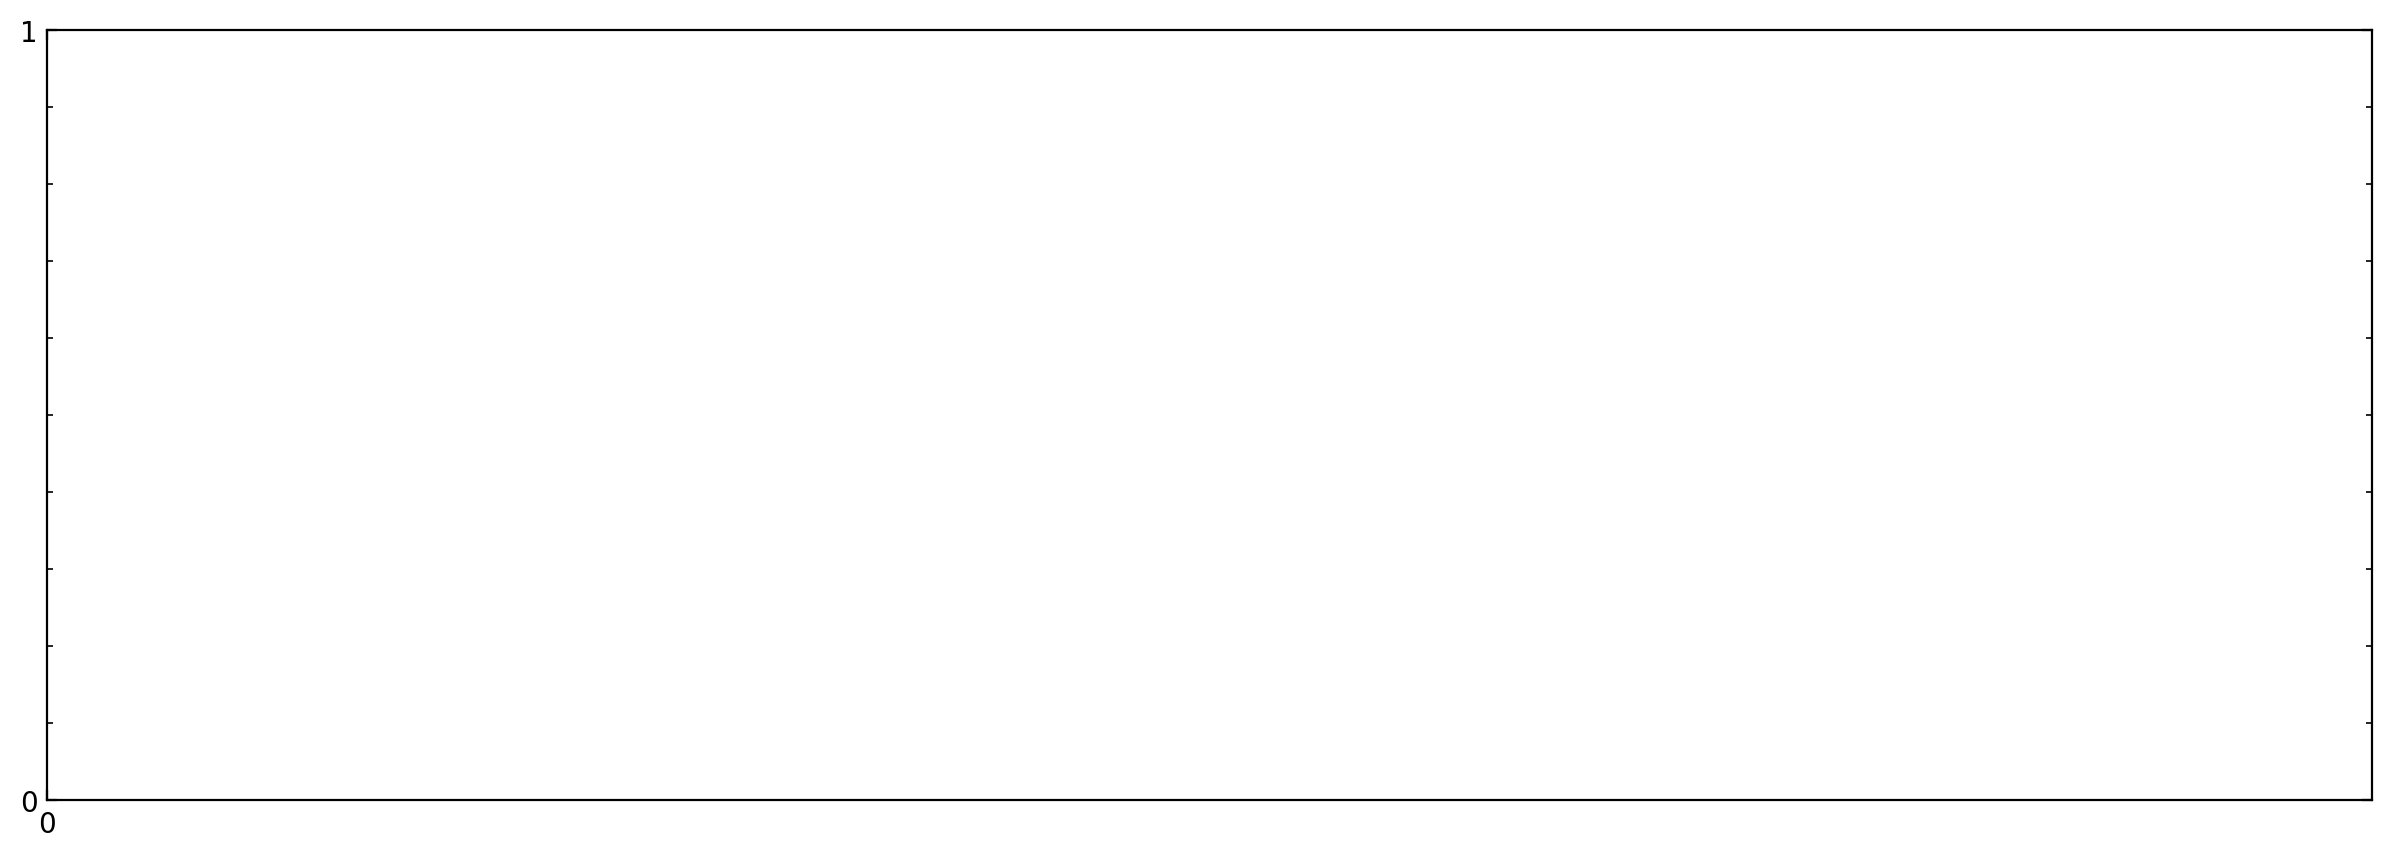

In [24]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=200)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(top=True, right=True, which='both', direction='in')



In [25]:
((105.29-104.45)/104.45)*100

0.8042125418860732

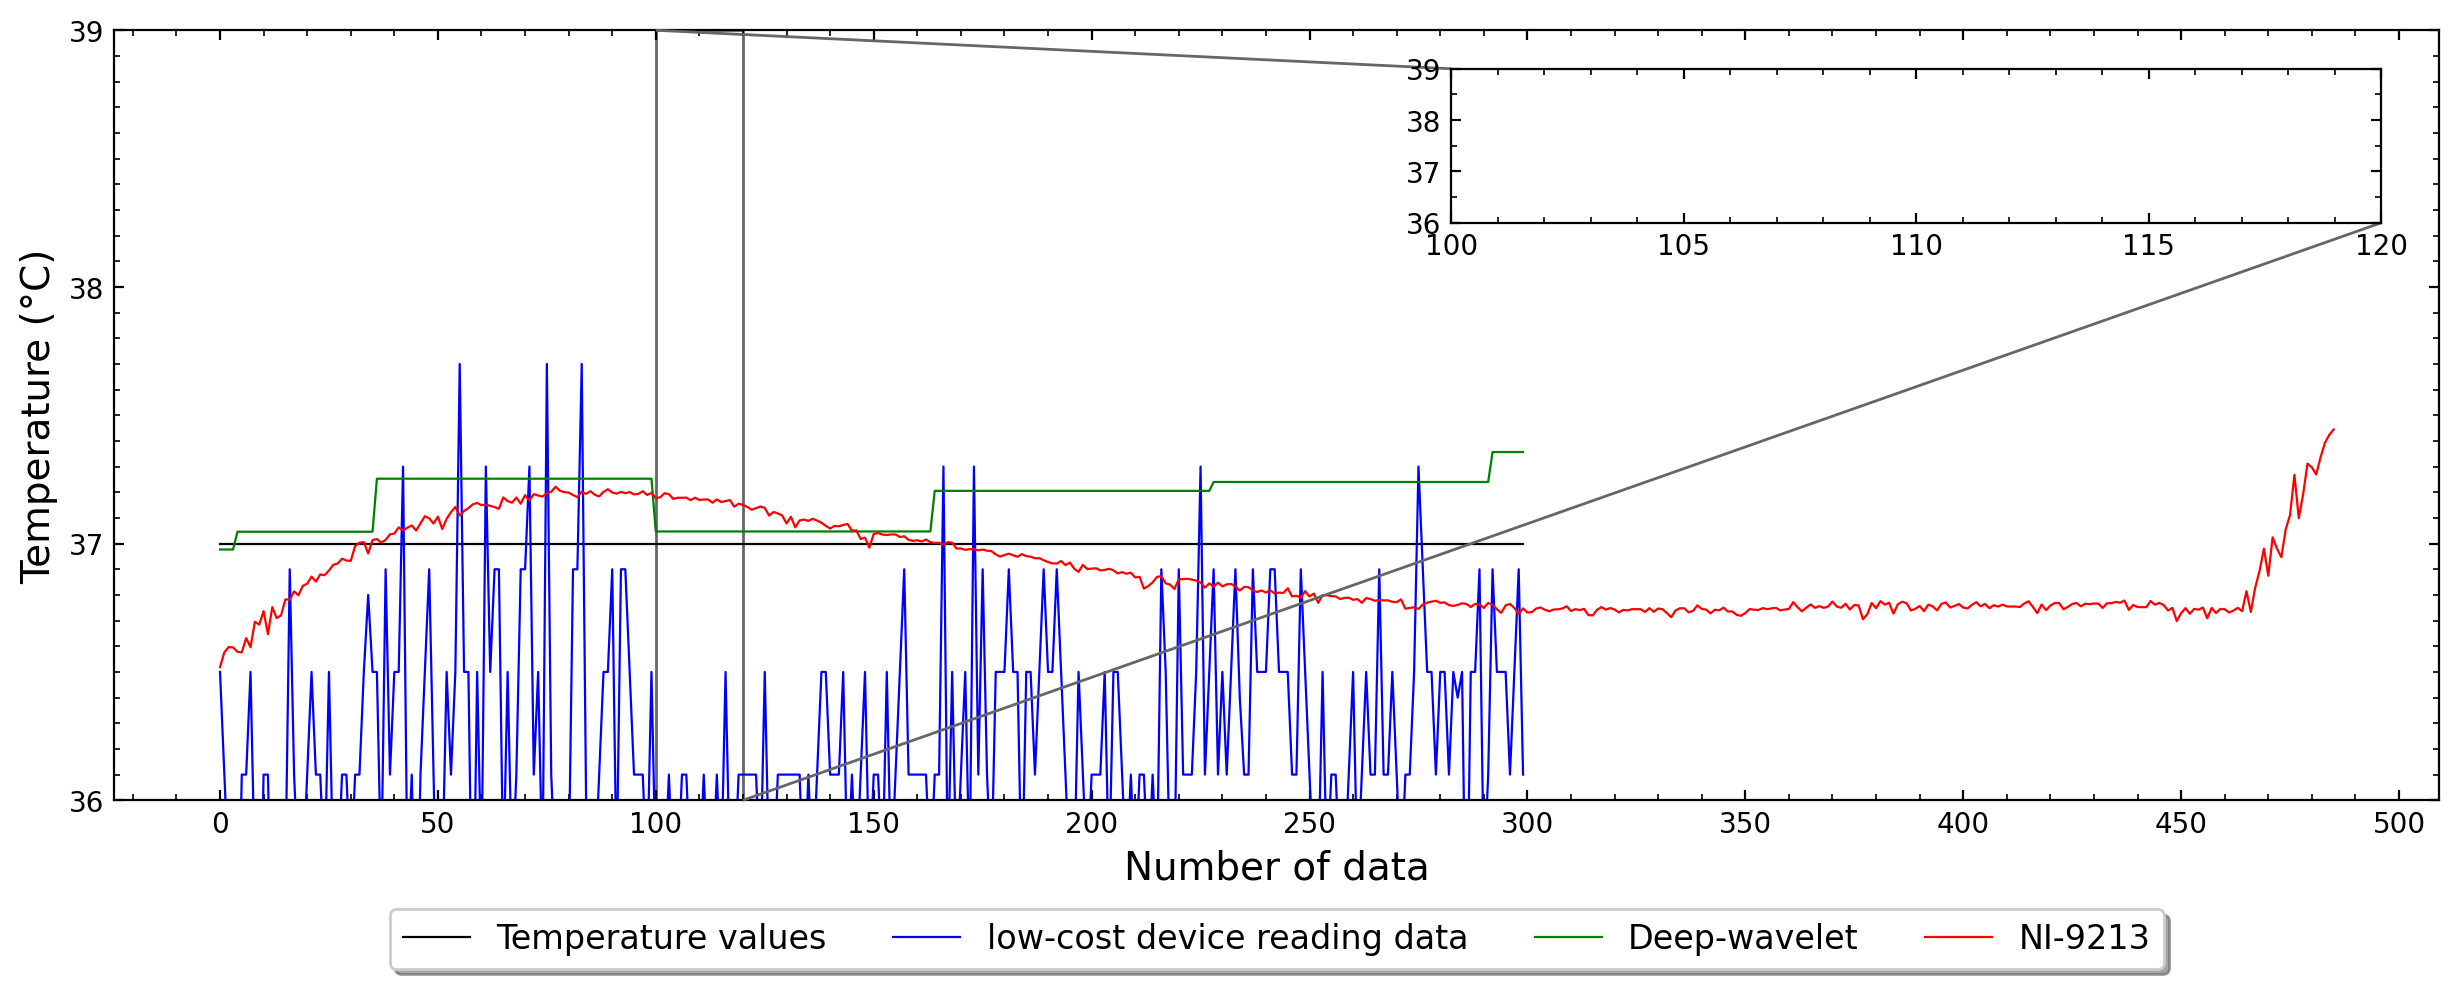

In [26]:
fig, ax = plt.subplots(1, figsize=(15, 5), dpi=200)
ax.yaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_major_formatter('{x:.0f}')
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.tick_params(top=True, right=True, which='both', direction='in')


markers = ['.', 'o', 's', '^', 'v']
colors = ['black', 'blue', 'green', 'red', 'purple']
labels = ["Temperature values", "low-cost device reading data", "Deep-wavelet", "NI-9213"]
HOP_LENGTH = 5
N_DATA = 292


ax.plot(actual_dict["37"].to_numpy()        , label=labels[0], linewidth=0.8, color=colors[0])
ax.plot(raw_dict["37"].to_numpy()           , label=labels[1], linewidth=0.8, color=colors[1])
ax.plot(Sensor_dict["37"]                   , label=labels[2], linewidth=0.8, color=colors[2])
ax.plot(NI_dict["37"]                       , label=labels[3], linewidth=0.8, color=colors[3])

ax.set_ylim([36,39])

ax_zoom = ax.inset_axes([0.575, 0.75, 0.4, 0.2]) 
mark_inset(ax, ax_zoom, loc1=2, loc2=4, fc="none", ec="0.4")
ax_zoom.set_ylim(36, 39)
ax_zoom.set_xlim(100, 120)
ax_zoom.yaxis.set_major_locator(MultipleLocator(1))
ax_zoom.yaxis.set_minor_locator(MultipleLocator(0.5))
ax_zoom.xaxis.set_major_locator(MultipleLocator(5))
ax_zoom.xaxis.set_major_formatter('{x:.0f}')
ax_zoom.xaxis.set_minor_locator(MultipleLocator(1))
ax_zoom.tick_params(top=True, right=True, which='both', direction='in')





ax.set_xlabel("Number of data", fontsize=14)
ax.set_ylabel("Temperature (°C)", fontsize=14)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5, fontsize=12, markerscale=2)

plt.show()

In [27]:
((8.59-0.2)/8.59)*100

97.67171129220024